In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('D:\\6OHDA\\')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package
import matplotlib.cm as cm
import statsmodels.api as sm
from matplotlib.patches import Rectangle

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
miceList = getMiceList(Files[0])

In [4]:
#path to folder where figures should be saved
figFolder = 'D:\\6OHDA\\submission2\\'

In [5]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

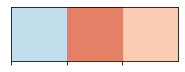

In [6]:

a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# a3 = np.concatenate((a3[2,:],a3[4:,:]))
colorPallet3Post =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3Post)) 



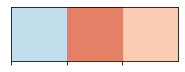

In [7]:
# set color pallet:
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# colorPallet3 =(a3[[2,6,5],:])
colorPallet3 =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3))

<h2> Calculate session stats for results sction 1 </h2>

In [8]:
df = pd.DataFrame()
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: (day >14)&(day<35)}

for per in periods.keys():
    data = getData(Files[1],['trace'],period ='Pre',day =periods[per])
    for sess in data.keys():
        m = sess[:4]
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])
        cre = getCreType(Files[1],m)
        numred = int(data[sess]['trace']['numred'])
        
        df= df.append({'mouse':m,'sess':sess,'day':day,
                       'period': periodCalc(day),'cre':cre,
                       'numred':numred,'numMsn':data[sess]['trace']['dff'].shape[0]},ignore_index=True)

d:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
cleaning up trace data
cleaning up trace data


In [9]:
df[~df.mouse.isin(['1253','1231'])].groupby(['period','cre']).agg([np.mean,sci.stats.sem])

day                numMsn               numred          
                  mean       sem        mean        sem      mean       sem
period  cre                                                                
Acute   CHI   6.645161  0.636773   82.387097  13.205300  1.064516  0.185121
        NA    7.000000  0.828417  136.277778  21.081511  0.000000  0.000000
        PV    6.418182  0.466155  185.563636  19.160386  2.454545  0.352784
Chronic CHI  24.176471  1.879133   95.117647  13.868575  1.117647  0.240746
        NA   21.333333  2.242271  207.555556  29.403850  0.000000  0.000000
        PV   23.066667  1.930869  183.466667  46.816243  1.000000  0.258199
Healthy CHI   0.000000  0.000000  187.666667  53.700108  1.466667  0.412503
        NA    0.000000  0.000000  155.444444  14.013001  0.000000  0.000000
        PV    0.000000  0.000000  184.166667  29.495015  1.833333  0.345371

In [11]:
df[~df.mouse.isin(['1253','1231'])].groupby(['period']).agg([np.mean,sci.stats.sem])
df[~df.mouse.isin(['1253','1231'])].to_csv(figFolder+'numberNeurons.csv')

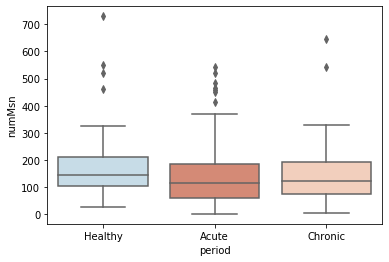

In [10]:
with sns.color_palette(colorPallet3):  
    sns.boxplot(x = "period",y = "numMsn",data = df[~df.mouse.isin(['1253','1231'])])

<h2> Figures </h2>

<h3> Figure 1 </h3>

D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
D:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up trace data
cleaning up lfp data
cleaning up speed data


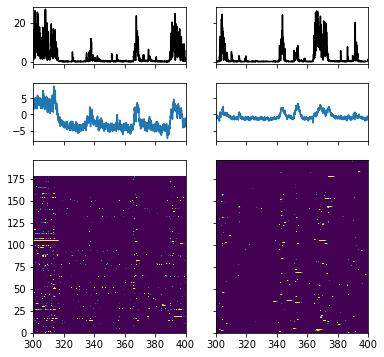

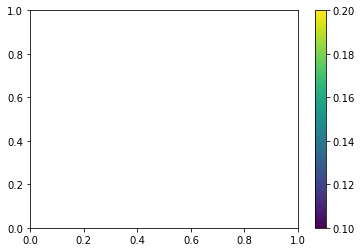

In [24]:
f = h5py.File('Spectograms.hdf5','r')

egSess = ['1236_BaselineS','1236_day30A']
egMouse = '1236'
data = getData(Files[1],['lfp','speed','trace'],period ='Pre',day =lambda day: (day==30) or (day==0), mice = [egMouse])

# plot lfp example:
fig, ax = plt.subplots(3,2,figsize=(6,6),sharex='col',sharey='row',gridspec_kw={'height_ratios': [1,1,3]})
# fig2, ax2 = plt.subplots(2,2,figsize=(6,3),sharex='col',gridspec_kw={'height_ratios': [1,3]})
for tPoint in range(0,2):
    sess = egSess[tPoint]
    dtS = 1/data[sess]['speed']['Fs']
    dtL = 1/data[sess]['lfp']['FS']
    ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
    tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

    ax[0,tPoint].plot(ts[6000:8001],data[sess]['speed']['speed'][0,6000:8001],color='black')
    
    ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape[1])) * dtS 
    dff = data[sess]['trace']['dff']
    dff = dff.T-np.nanmean(dff,axis=1)
    dff = dff.T
    dsum = np.sum((dff[:,6000:8001]),axis=0)
    ax[1,tPoint].plot(ts[6000:8001],dsum)
    
#     lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
#     lfp = data[sess]['lfp']['lfp']
#     lfp[(lfpOutliers[:,0]==1)] = np.nan
#     ax2[0,tPoint].plot(tl[0:5000],lfp[0:5000])

#     freq = f[egMouse]['freq'].value
#     coeff = np.abs(f[egMouse][sess]['Pre']['coeff'].value)
    
#     coeff[:,(lfpOutliers[:,0]==1)] = np.nan

#     ax2[1,tPoint].pcolormesh(tl[0:5000],freq,coeff[:,0:5000], rasterized=True)
    CS = ax[2,tPoint].pcolormesh(ts[6000:8001],np.arange(0,dff.shape[0]),dff[:,6000:8001],vmax=.2,vmin=0.1, rasterized=True)
    
    
# fig.savefig(figFolder+'figure1a_Ca.png')
# fig.savefig(figFolder+'figure1a_Ca.svg',transparent=True)
fig2, ax = plt.subplots(1,1)
fig2.colorbar(CS)
# fig2.savefig(figFolder+'figure1a_lfp_'+str(egSess[0])+"_"+str(egSess[1][5:])+'.png')
fig2.savefig(figFolder+'figure1a_colorbar.svg',transparent=True)

<h3> Figure 2 </h3>

d:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up speed data
cleaning up rot data


d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


(260, 360)

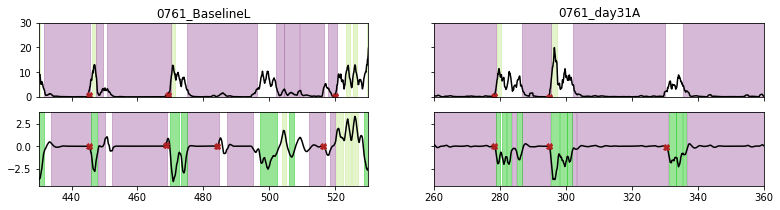

In [11]:
#Figure 2A
m = "0761"
sessList = [m+"_BaselineL",m+"_day31A"]
data = getData(Files[1],['speed','rot'],period ='Pre', mice=m, day = lambda x: (x==0) or (x==31))
conds = ['high','low','stright','ipsi','contra']
Color = CP('highLowSpeed')
Color['stright'] =Color['low'] #'tomato'
Color['ipsi']='limegreen'
Color['contra']=Color['high']
indX = 0
fig, ax  = plt.subplots(2,2,figsize=(13,3),sharey='row',sharex='col')
for sess in sessList:
    segments = {'high':{'ax':0,'start':getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')},
                'low':{'ax':0,'start':getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')},
                'stright':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','loPeriods_EndSegments')},
                'ipsi':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','hiACPeriods_EndSegments')},
                'contra':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','hiCPeriods_EndSegments')}}
    sOnset =  getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
    speed = data[sess]['speed']['speed'].T
    
    rOnset =  getOnsetOrPeriod(m,sess,'Pre','rotOnset')
    rot = data[sess]['rot']['rot'].T
    
    t = np.arange(0,len(speed))*0.05
    ax[0,indX].plot(t,smooth(speed,20),color='black')
    ax[1,indX].plot(t,smooth(rot,20),color='black')
    for cond in conds:
        for l in range(0, len(segments[cond]['start'])):
            ax[segments[cond]['ax'],indX].axvspan(t[segments[cond]['start'][l]], t[segments[cond]['end'][l]], color= Color[cond], alpha=0.5)
    ax[0,indX].plot(t[sOnset],speed[sOnset],'X',color='firebrick')
    ax[0,indX].set_ylim(0,30) 
    ax[1,indX].plot(t[rOnset],rot[rOnset],'X',color='firebrick')
    ax[0,indX].set_title(sess)
    indX = indX+1
ax[1,0].set_xlim(430,530)
ax[1,1].set_xlim(260,360)
#ax[1,1].set_ylim(-2.2,2)

#fig.savefig(figFolder+'figure2_mvmtOnset.png')
# fig.savefig(figFolder+'figure2_mvmtOnset.svg',transparent=True)

In [127]:
speedData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['speed'],period ='Pre', mice=m)
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
        comb = Hp*1+((Lp*1)-1)*-1
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high'] = np.sum(Hp*1)/len(Hp)
        row['percent_medium'] = np.sum(comb==1)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['tran_all'] = np.sum(np.abs(trans!=0))
        row['tran_low2any'] = np.sum(np.abs(Lp[1:]*1-Lp[:-1]*1))
        row['tran_high2any'] = np.sum(np.abs(Hp[1:]*1-Hp[:-1]*1))
        
        row['MvmtOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','mvmtOnset'))        
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
df.to_csv(figFolder+'speedData.csv')

D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data


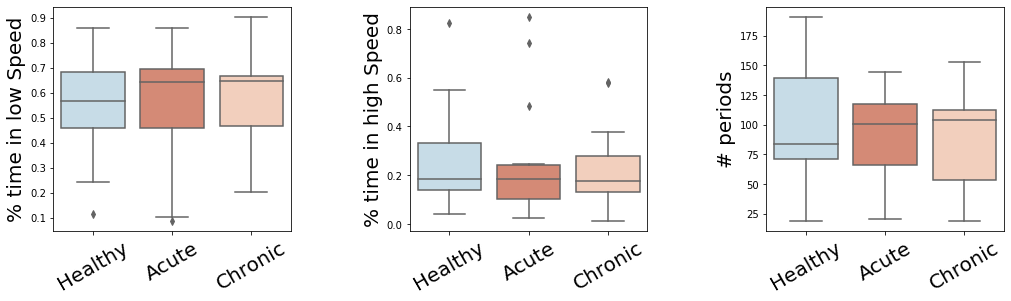

In [14]:
#figure 2B 
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high','tran_low2any'] 
    labels = ['% time in low Speed','% time in high Speed','# periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder)
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(labels[ind],fontsize=20)
        ax[ind].set_xlabel("")
        
        
#fig.savefig(figFolder+'figure2_abc.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b1.svg',transparent=True,format='svg')


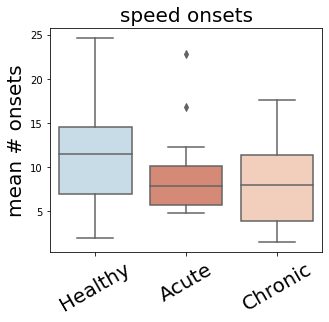

In [16]:
#Figure 2Div
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,1,figsize=(4.88,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['MvmtOnset'] 
    labels = ['speed onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax,order = pOrder)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=20)
        ax.set_ylabel("mean # onsets",fontsize=20)
        ax.set_xlabel("")
        ax.set_title(labels[ind],fontsize=20)
        
#fig.savefig(figFolder+'figure2_b3.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b3.svg',transparent=True,format='svg')


In [18]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Pre', mice=m)
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','rotOnset2')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset2'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset2'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row: periodCalc(row.Day) , axis=1)
dfRot.to_csv(figFolder+'rotation_forR.csv')

D:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data


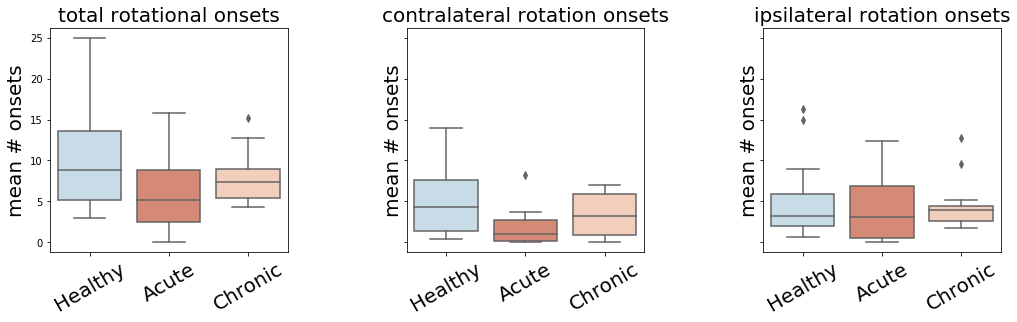

In [16]:
#Figure 2Di-iii
dfRot = pd.read_csv(figFolder+'rotation_forR.csv')
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey = True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['rotOnset','cRotOnset','acRotOnset'] 
    labels = ['total rotational onsets','contralateral rotation onsets','ipsilateral rotation onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel("mean # onsets",fontsize=20)
        ax[ind].set_xlabel("")
        ax[ind].set_title(labels[ind],fontsize=20)

#fig.savefig(figFolder+'figure2c_1.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2c_1.svg',transparent=True,format='svg')


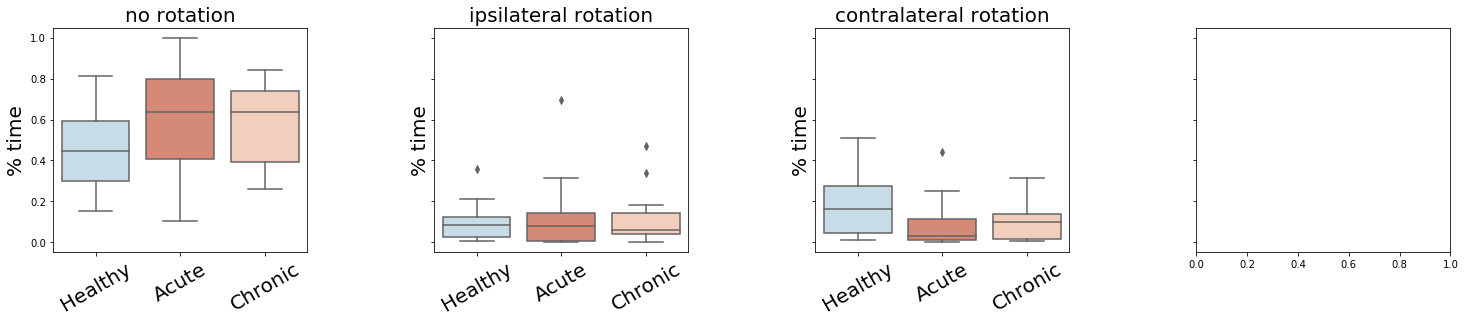

In [19]:
# Figure 2C
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,4,figsize=(25.04,4.88),sharey=True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high_AC','percent_high_C'] 
    labels = ['no rotation','ipsilateral rotation',
              'contralateral rotation','']
    Ylabels = ['% time','% time','% time','# rotation periods']
    for ind in range(len(columns)):
        if ind <3:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax[ind].set_ylabel(Ylabels[ind],fontsize=20)
            ax[ind].set_xlabel("")  
            ax[ind].set_title(labels[ind],fontsize=20)     

#fig.savefig(figFolder+'figure2c_2.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2c_2.svg',transparent=True,format='svg')
# fig2.savefig(figFolder+'figure2c_2b.svg',transparent=True,format='svg')


<h3> Figure 3 </h3>

cleaning up trace data


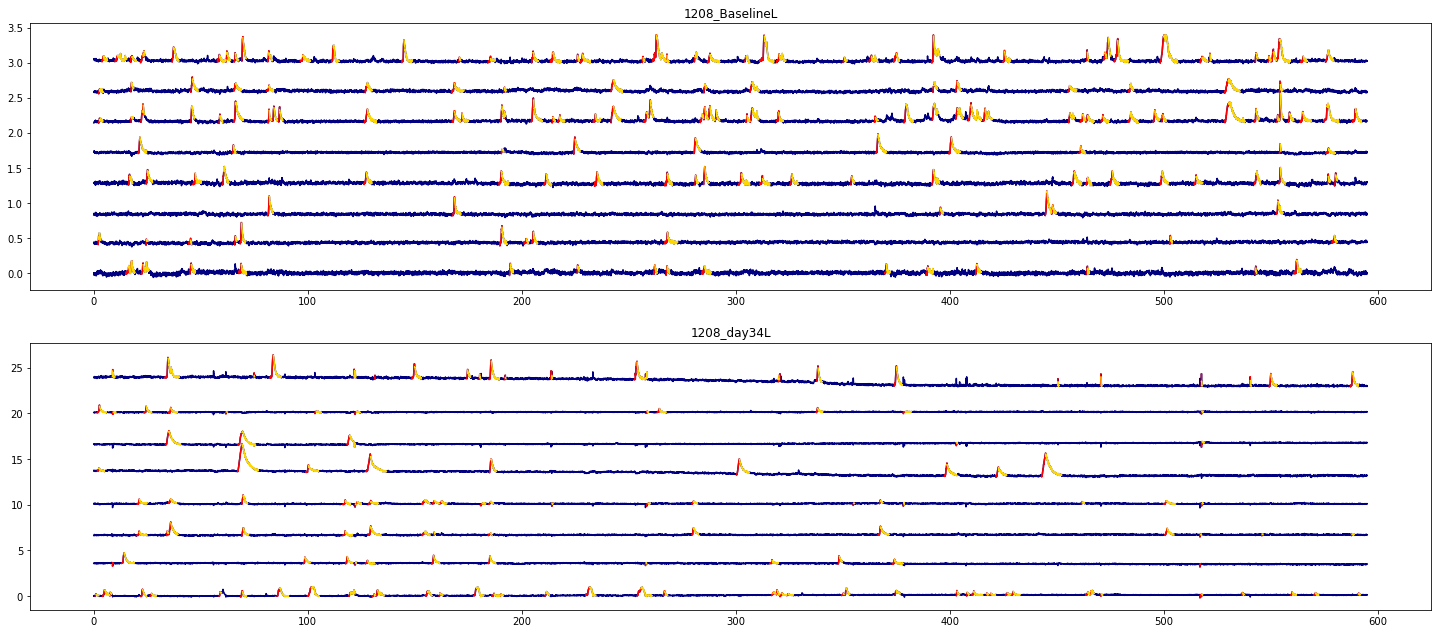

In [36]:
#Figure 3Ai
warnings.filterwarnings("ignore")

f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
sessList = {'1208_BaselineL':27,'1208_day34L':5}
m = '1208'
data = getData(Files[1],['trace'],period ='Pre',day =lambda day: (day==34) or (day==0), mice = [m])

# constents for analysis:
tracePerSlide = 8
colors = {'TD':'black','TD_skip':'indianred','MSN':'navy','MSN_skip':'royalblue'}
lf = {'left':0.30, 'top':1.30, 'height':10.80, 'width':25.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

fig, ax = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
fig.set_size_inches(lf['width'],lf['height'],forward=True)

indX = 0
for sess in sessList.keys():
    # get traces:
    dff = data[sess]['trace']['dff']
    dt = 1/data[sess]['trace']['FS'][0]
    t = np.linspace(0,dt*dff.shape[1],dff.shape[1])
    Fs = data[sess]['trace']['FS'][0]
    # Vectors are saved as column vectors so.. transposed to raw vector
    if dff.shape[1] == 1:
        dff = dff.T
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caFall =  f[m][sess]['Pre']['caFall_Hf'].value
    caOnset[caOnset==0] =np.nan
    caFall[caFall==0] =np.nan
    numred = int(data[sess]['trace']['numred'][0])

    tLim = int(600*Fs)
    N = sessList[sess]
    endN = np.min(((N+1)*tracePerSlide,dff.shape[0]))
    T=0;
    endT = np.min(((T+1)*tLim,dff.shape[1]))
    df = dff[N*tracePerSlide:endN,T*tLim:endT]
    ca = caOnset[N*tracePerSlide:endN,T*tLim:endT]
    ca = ca*df
    cf = caFall[N*tracePerSlide:endN,T*tLim:endT]
    cf = cf*df
    spacing = np.max(np.abs(df))
    Color = ['navy' for x in range(0,df.shape[0])]
    if tracePerSlide*N <numred:
        Nl = min(tracePerSlide,numred-N*tracePerSlide)
        Color[0:Nl] = [colors['TD'] for x in range(0,Nl)]
        Color[Nl:] = [colors['MSN'] for x in range(Nl,len(Color))]
    else:
        Color = [colors['MSN'] for x in range(0,len(Color))]
    for d in range(0,df.shape[0]):
        ax[indX].plot(t[T*tLim:endT],df[d,:]+d*spacing,color=Color[d],rasterized=True) 
        ax[indX].plot(t[T*tLim:endT],ca[d,:]+d*spacing,color='red',rasterized=True)
        ax[indX].plot(t[T*tLim:endT],cf[d,:]+d*spacing,color='gold',rasterized=True)
    ax[indX].set_title(sess)
    indX = indX+1
#fig.savefig(figFolder+'figure3_eventDetection'+'.png')
# fig.savefig(figFolder+'figure3_eventDetection_rasterized'+'.svg',transparent=True)




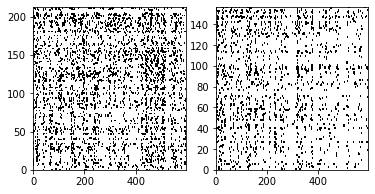

In [25]:
#Figure 3Aii
warnings.filterwarnings("ignore")

f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
sessList = {'1208_BaselineS':10,'1208_day34L':10}
m = '1208'

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex='col')
indX = 0
for sess in sessList.keys():
    # get traces:
    
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caOnset[caOnset==0] = np.nan
    ts = np.arange(0, np.max(caOnset.shape[1])) * .05 
    ax[indX].pcolormesh(ts[:],np.arange(0,caOnset.shape[0]),caOnset[:,:],cmap=cm.gray,rasterized=True)
    indX =indX+1
    

# fig.savefig(figFolder+'figure3_binaryRastor'+'.png')
# fig.savefig(figFolder+'figure3_binaryRastor_rasterized2'+'.svg',transparent=True)




In [38]:
# data for all mice - homomorphic filter 
PVdata = getData(Files[1],['speed','trace'],period ='Pre', cre='PV',red = True)
MSNdata = getData(Files[1],['speed','trace'],period ='Pre',red = False)
CHIdata = getData(Files[1],['speed','trace'],period ='Pre', cre='CHI',red = True)


cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 7584_day0
I deleted session: 7909_day30A
I deleted session: 8430_BaselineA
I deleted session: 8430_day1
I deleted session: 8430_day15A
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day30A
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day12
I deleted session: 0761_day14A
I deleted session: 0761_day2
I deleted session: 0761_day31A
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day20L
I deleted session: 1222_day3
I deleted session: 1222_day32A
I deleted session: 1222_day36L
I deleted session: 1222_day5
I deleted s

In [39]:
#f = h5py.File('OnsetsAndPeriods.hdf5','r')
col_names = ['Mouse','Sess','Day','highSpeed','medSpeed','lowSpeed','All_',
             'acc','dcc','rotAcc','rotDcc','highACrot','highCrot','lowRot']
dfC = pd.DataFrame(columns = col_names)
cond = ['PVdata','MSNdata','CHIdata']
transWindow = np.ones((10,1))
for c in cond:
    data = eval(c)
    for sess in data.keys():
#         try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]

            Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            Mp = ((Hp+Lp)==0)
            hACp = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            hCp = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            Lrp = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            comb = hACp*8+Lp*5+hCp*7
            rotTrans = comb[1:]-comb[:-1]           
            
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
            numRed = int(data[sess]['trace']['numred'])
            if c in ['PVdata','CHIdata']:
                Ca = Ca[:numRed,:]
            else:
                Ca = Ca[numRed+1:,:]
            CaO = Ca[:,1:]-Ca[:,:-1]
            if CaO.shape[1]<Hp.shape[0]:
                 CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
            C_start = (CaO==1)*1
            C_end = (CaO==-1)*1
            Acc = np.append(np.convolve(np.diff(Lp*1+Hp*2)>0, transWindow[:,0], mode='same')>0,False)
            Dcc = np.append(np.convolve(np.diff(Lp*1+Hp*2)<0, transWindow[:,0], mode='same')>0,False)
            rotAcc = np.append(np.convolve(rotTrans>0, transWindow[:,0], mode='same')>0,False)
            rotDcc = np.append(np.convolve(rotTrans<0, transWindow[:,0], mode='same')>0,False)
            if rotAcc.shape[0] >Acc.shape[0]:
                rotAcc = rotAcc[:Acc.shape[0]]
                rotDcc = rotDcc[:Acc.shape[0]]
                    

            
            a = np.asarray([np.sum(C_start[:,Hp],axis=1),np.sum(C_start[:,Mp],axis=1),
                            np.sum(C_start[:,Lp],axis=1),np.sum(C_start,axis=1),
                            np.sum(C_start[:,Acc],axis=1),np.sum(C_start[:,Dcc],axis=1),
                            np.sum(C_start[:,rotAcc],axis=1),np.sum(C_start[:,rotDcc],axis=1),
                            np.sum(C_start[:,hACp],axis=1),np.sum(C_start[:,hCp],axis=1),
                            np.sum(C_start[:,Lrp],axis=1)]).T
            
            df2C = pd.DataFrame(a, columns = col_names[3:])
            df2C['totalTime'] = (Hp.shape[0]/1200)
            df2C['lowTime'] = np.sum(Lp/1200)
            df2C['medTime'] = np.sum(Mp/1200)
            df2C['highTime'] = np.sum(Hp/1200)
            df2C['lowRotTime'] = np.sum(Lp/1200)
            df2C['highACRotTime'] = np.sum(hACp/1200)
            df2C['highCRotTime'] = np.sum(hCp/1200)
            df2C['totTrans'] = np.sum(rotTrans!=0)
            df2C['rotAccTrans'] = np.sum(rotTrans>0)
            df2C['rotDccTrans'] = np.sum(rotTrans<0)
            df2C['accTrans'] = np.sum(np.diff(Lp*1+Hp*2)>0)
            df2C['dccTrans'] = np.sum(np.diff(Lp*1+Hp*2)<0)
            df2C['Day'] = day
            df2C['Mouse'] = m
            df2C['Sess'] = sess
            df2C['CellType'] = c[:-4]
            df2C['Period'] = periodCalc(day)
            dfC = pd.concat([dfC,df2C],sort=True)
#         except:
#             print(sess)


dfC['high_speed'] =  dfC.apply (lambda row: row.highSpeed/row.highTime if row.highTime != 0 else None, axis=1)
dfC['medium_speed'] = dfC.apply (lambda row: row.medSpeed/row.medTime, axis=1)
dfC['low_speed'] = dfC.apply (lambda row: row.lowSpeed/row.lowTime , axis=1)
dfC['high_ACrot'] =  dfC.apply (lambda row: row.highACrot/row.highACRotTime if row.highACRotTime != 0 else None, axis=1)
dfC['high_Crot'] = dfC.apply (lambda row: row.highCrot/row.highCRotTime if row.highCRotTime != 0 else None, axis=1)
dfC['low_rot'] = dfC.apply (lambda row: row.lowRot/row.lowRotTime if row.lowRotTime != 0 else None, axis=1)
dfC['All'] = dfC.apply (lambda row: row.All_/row.totalTime , axis=1)
dfC['Acc'] = dfC.apply (lambda row: row.acc/row.accTrans , axis=1)
dfC['Dcc'] = dfC.apply (lambda row: row.dcc/row.dccTrans , axis=1)
dfC['Acc_'] = dfC.apply (lambda row: row.acc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['Dcc_'] = dfC.apply (lambda row: row.dcc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['rotAcc'] = dfC.apply (lambda row: row.rotAcc/row.rotAccTrans , axis=1)
dfC['rotDcc'] = dfC.apply (lambda row: row.rotDcc/row.rotDccTrans , axis=1)
dfC['rotAcc_'] = dfC.apply (lambda row: row.rotAcc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['rotDcc_'] = dfC.apply (lambda row: row.rotDcc/row.All_ if row.All_ >0 else 0 , axis=1)


dfC['totAcc_'] = dfC.apply (lambda row: (row.dcc+row.acc)/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['totRotAcc_'] = dfC.apply (lambda row: (row.rotDcc+row.rotAcc)/row.All_ if row.All_ >0 else 0 , axis=1)


dfC.head()


dfC.to_csv(figFolder+'firingRateDf.csv')

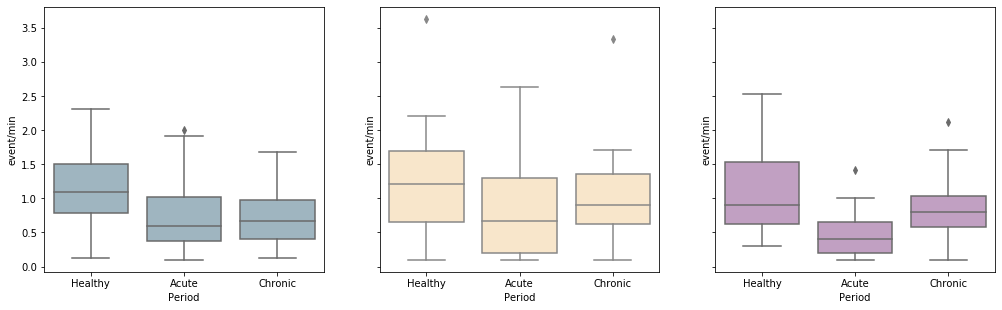

In [30]:
#Figure 3B
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','All']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['All'],value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
ind = 0
colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
    g = sns.boxplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                    order = ['Healthy', 'Acute', 'Chronic'],
                    color=colors[ind],ax=ax[ind])
    ind = ind +1
# fig.savefig(figFolder+'figure3_b.svg',transparent=True,format='svg')


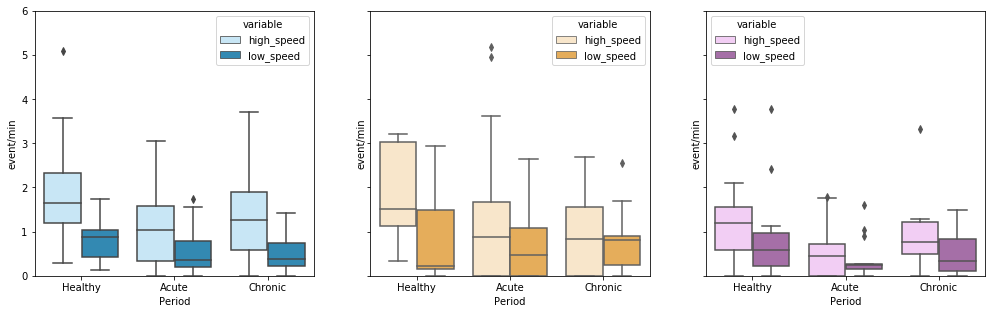

In [40]:
#Figure 3C
# for each cell, high and low speed on same plot - Average per session

dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_speed',
                        'low_speed', 'high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_speed', 'low_speed']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#c0e9fc','#1e91c7'], 'PV':['#FFE7C4','#fcb144'],'CHI':['#f8c8fa','#ad66b0']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Acute', 'Chronic'],
                   palette=colors[cell],ax=ax[indC])

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure3_c.svg',transparent=True,format='svg')
#HIGHSPEED

In [8]:
#  for all mice - by period
PV0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
PV1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: (x>0)& (x<13) )
PV2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>=13 )

CHI0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHI1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>0)& (x<13) )
CHI2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>=13 )

MSN0 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x==0)
MSN1 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: (x>0)& (x<13) )
MSN2 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x>=13 )

D:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up trace data
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 8430_day1
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 7909_day30A
I deleted session: 8430_day15A
I deleted session: 8803_day30A
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 0

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

Text(0.5, 1.0, 'speed')

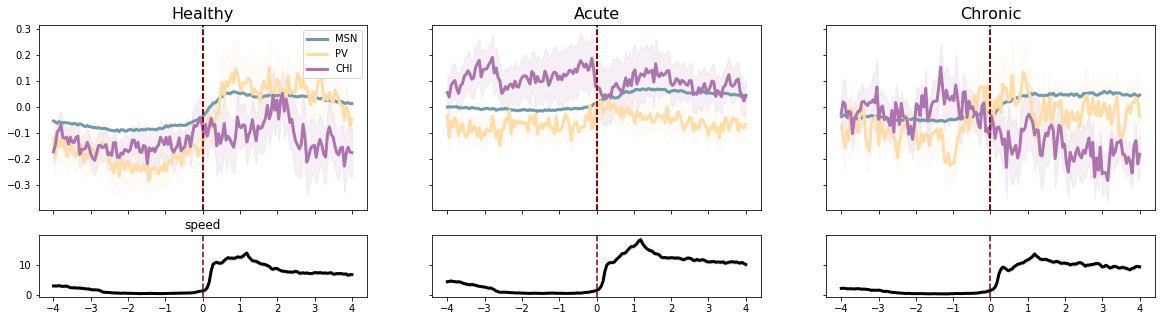

In [9]:
#Figure 3D
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row',gridspec_kw={'height_ratios': [3,1]})
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = {'Healthy':{},'Acute':{},'Chronic':{}}

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset = getOnsetOrPeriod(m,s,'Pre','mvmtOnset2')    
            if np.sum(sOnset) == 0:
                continue
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        quant[p][c] = sAligned
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            quant[p]['speed'] = sAlignedS
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

# fig.savefig(figFolder+'figure 4a.svg',transparent=True)

In [ ]:
# data for figure 3F,G
df = pd.DataFrame(columns=['Period','CellType','pre','post'])
for p in quant.keys():
    di = quant[p]
    for c in di.keys():
        bl = di[c][:80]
        mu = np.mean(bl)
        std = np.std(bl)
        tr = (di[c]-mu)/std
        df2 = pd.DataFrame({'Period':p,'CellType':c,'pre':np.mean(tr[:80],axis=0),'post':np.mean(tr[80:],axis=0)})
        df = pd.concat([df,df2])
df.to_csv(figFolder+'fig3E_quantification_2s.csv')

MSN
__________________________________________
Healthy : S =  -27.54944472034841  P-val =  1.0846507427913976e-159 True
Acute : S =  -18.198128556687923  P-val =  3.823332276462101e-73 True
Chronic : S =  -18.941755261752366  P-val =  1.8888847041946943e-78 True
__________________________________________
speed
__________________________________________
Healthy : S =  -30.007274078633134  P-val =  1.2986123546756365e-119 True
Acute : S =  -37.45921589421687  P-val =  4.755569959816885e-186 True
Chronic : S =  -30.344770592538246  P-val =  2.5150833102684528e-116 True
__________________________________________
PV
__________________________________________
Healthy : S =  -3.761859684590277  P-val =  0.0006803464279440823 True
Acute : S =  -1.3934093938630434  P-val =  0.16611512003626883 False
Chronic : S =  -1.351937763943293  P-val =  0.18650056591838204 False
__________________________________________
CHI
__________________________________________
Healthy : S =  -1.0150027116683875  P-

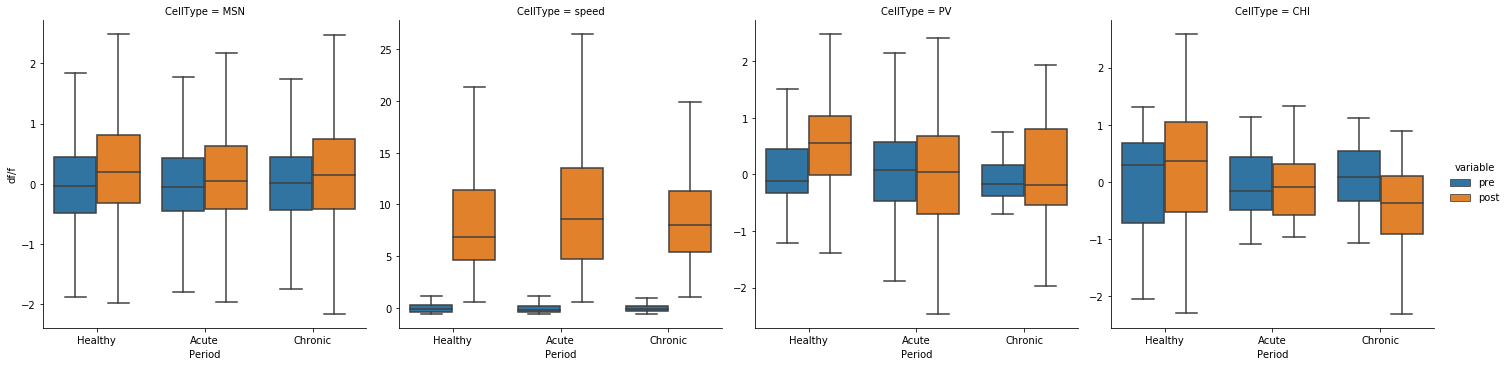

In [20]:
#Figure 3F
df = pd.read_csv(figFolder+'fig3E_quantification_2s.csv')
df2 = pd.melt(df,id_vars=['CellType','Period'], value_vars=['pre','post'],value_name='df/f')
df2
sns.catplot(x='Period',y='df/f',hue='variable',col='CellType',data=df2,
            kind='box',sharey=False,showfliers = False)
for c in df2.CellType.unique():
    print(c)
    print('__________________________________________')
    df3 = df[df.CellType==c]
    for p in df3.Period.unique():
        df4 = df3[df3.Period==p]
        #s,P  = sci.stats.wilcoxon(df4.pre, y=df4.post)
        s,P  = sci.stats.ttest_rel(df4.pre, df4.post)
        print(p,': S = ',s,' P-val = ',P,P<0.05)
    print('__________________________________________')
# plt.savefig(figFolder+'figure3S_prePost_mvmt_noFliers.svg',transparent=True)

MSN
 S =  68.04909544936159  P-val =  3.253218908541296e-30 True 30541
Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1  group2 meandiff p-adj lower  upper  reject
---------------------------------------------------
  Acute Chronic   0.0485 0.001 0.0201  0.077   True
  Acute Healthy   0.1456 0.001 0.1163 0.1749   True
Chronic Healthy   0.0971 0.001 0.0649 0.1293   True
---------------------------------------------------
Healthy 0.27999752418620955
Acute 0.13436952662043644
Chronic 0.18289359337936764
__________________________________________
speed
 S =  4.243968167566689  P-val =  0.014480898996718127 True 1989
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Acute Chronic  -0.8014 0.1567 -1.8223  0.2196  False
  Acute Healthy  -1.1682  0.015 -2.1527 -0.1837   True
Chronic Healthy  -0.3668 0.7049 -1.4887  0.7551  False
---------------------------------------

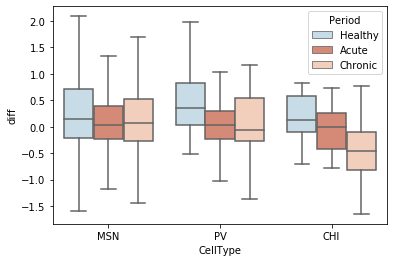

In [21]:
#Figure 3G
df = pd.read_csv(figFolder+'fig3E_quantification_2s.csv')
df['diff'] = df.apply(lambda x: x.post - x.pre, axis=1)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.boxplot(x='CellType',y='diff',hue='Period',data=df[df.CellType != 'speed'],palette=colorPallet3,showfliers=False)
for c in df.CellType.unique():
    print(c)
    #print('__________________________________________')
    df3 = df[df.CellType==c]
    s,P  = sci.stats.f_oneway(df3[df3.Period=='Healthy']['diff'].values, 
                              df3[df3.Period=='Acute']['diff'].values, df3[df3.Period=='Chronic']['diff'].values)
    print(' S = ',s,' P-val = ',P,P<0.05,df3['diff'].count())
    
    m_comp = pairwise_tukeyhsd(endog=df3['diff'].astype(float), groups=df3.Period, alpha=0.05)
         
    print(m_comp)
    for p in df3.Period.unique():
        print(p,df3[df3.Period==p]['diff'].mean())
    print('__________________________________________')
# plt.savefig(figFolder+'figure3E_new_mvmt.svg',transparent=True)


In [ ]:
numIter = 1000
col_names = ['Mouse','Sess','Day','n','diff_speed','s2_5','s97_5','s95','diff_rot','r2_5','r97_5','r95']
dfC = pd.DataFrame(columns = col_names)
cond = ['PVdata','MSNdata','CHIdata']
transWindow = np.ones((10,1))
for c in cond:
    data = eval(c)
    for sess in data.keys():
#         try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]

            Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            Hrot = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')+getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            Lrot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
                
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
            numRed = int(data[sess]['trace']['numred'])
            if c in ['PVdata','CHIdata']:
                Ca = Ca[:numRed,:]
            else:
                Ca = Ca[numRed:,:]
            
            Ca = Ca[np.sum(Ca,axis=1)>0,:]
            if Ca.shape[0]==0:
                continue
            CaO = Ca[:,1:]-Ca[:,:-1]
            if CaO.shape[1]<Hp.shape[0]:
                 CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
            C_start = (CaO==1)*1
            
            shuffles = np.zeros((C_start.shape[0],numIter,2))
            
            lowTime = np.sum(Lp/1200)
            highTime = np.sum(Hp/1200)
            lowRTime = np.sum(Lrot/1200)
            highRTime = np.sum(Hrot/1200)
            
            for it in range(numIter):
                shifts = np.random.randint(size= C_start.shape[0],low=0,high=C_start.shape[1])
                C = circShiftRoll(shifts,C_start)
                shuffles[:,it,0] = (np.sum(C[:,Hp],axis=1)/highTime)-(np.sum(C[:,Lp],axis=1)/lowTime)
                shuffles[:,it,1] = (np.sum(C[:,Hrot],axis=1)/highRTime)-(np.sum(C[:,Lrot],axis=1)/lowRTime)
            
           
        
            a = np.asarray([np.arange(C_start.shape[0]),
                            (np.sum(C_start[:,Hp],axis=1)/highTime)-(np.sum(C_start[:,Lp],axis=1)/lowTime),
                            np.nanpercentile(shuffles[:,:,0],2.5,axis=1),
                            np.nanpercentile(shuffles[:,:,0],97.5,axis=1),
                            np.nanpercentile(shuffles[:,:,0],95,axis=1),
                            (np.sum(C_start[:,Hrot],axis=1)/highRTime)-(np.sum(C_start[:,Lrot],axis=1)/lowRTime),
                            np.nanpercentile(shuffles[:,:,1],2.5,axis=1),
                            np.nanpercentile(shuffles[:,:,1],97.5,axis=1),
                            np.nanpercentile(shuffles[:,:,1],95,axis=1)]).T
            
            df2C = pd.DataFrame(a, columns = col_names[3:])
            df2C['Day'] = day
            df2C['Mouse'] = m
            df2C['Sess'] = sess
            df2C['CellType'] = c[:-4]
            df2C['Period'] = periodCalc(day)
            dfC = pd.concat([dfC,df2C],sort=True)
#         except:
#             print(sess)


dfC.head()


dfC.to_csv(figFolder+'firingRateDiff.csv')

In [23]:
dfC =pd.read_csv(figFolder+'firingRateDiff.csv')
dfC['care'] = dfC.apply(lambda x: (x.diff_speed>x.s97_5)or(x.diff_speed<x.s2_5),axis=1)
dfC['care_rot'] = dfC.apply(lambda x: (x.diff_rot>x.r97_5)or(x.diff_rot<x.r2_5),axis=1)
dfC.head()

,Unnamed: 0,CellType,Day,Mouse,Period,Sess,diff_rot,diff_speed,n,r2_5,r95,r97_5,s2_5,s95,s97_5,care,care_rot
0,0,PV,0,1236,Healthy,1236_BaselineA,-0.164858,-0.147783,0.0,-0.164858,0.682982,0.682982,-0.147783,0.604534,0.604534,False,False
1,1,PV,0,1236,Healthy,1236_BaselineA,2.567072,2.727104,1.0,-1.318862,1.719231,2.237356,-1.330049,1.679220,1.827003,True,True
2,0,PV,0,1236,Healthy,1236_BaselineS,0.442357,0.929099,0.0,-1.399417,1.594500,1.944354,-1.341615,1.560061,1.858198,False,False
3,1,PV,0,1236,Healthy,1236_BaselineS,0.000000,-0.149068,1.0,-0.174927,0.617284,0.617284,-0.149068,0.539084,0.539084,False,False
4,0,PV,11,1236,Acute,1236_day11,-0.126011,-0.127146,0.0,-0.252021,1.133171,1.259182,-0.254291,1.128085,1.255230,False,False


--------------------------------
care PV
Healthy 1.0 False   5 / 23
Acute 0.28227883988228064 False   6 / 56
Chronic 0.7009739352337199 False   3 / 21
--------------------------------
care MSN
Healthy 1.0 False   1604 / 7837
Acute 2.1269278292294235e-08 True   1690 / 9850
Chronic 0.03958746122644404 False   1248 / 6539
--------------------------------
care CHI
Healthy 1.0 False   4 / 22
Acute 0.3554546449283295 False   1 / 18
Chronic 1.0 False   2 / 16
--------------------------------
care_rot PV
Healthy 1.0 False   5 / 23
Acute 0.0014930217461863043 True   0 / 56
Chronic 0.4160685457480687 False   2 / 21
--------------------------------
care_rot MSN
Healthy 1.0 False   1140 / 7837
Acute 1.3991403333222644e-83 True   577 / 9850
Chronic 0.8868155988309264 False   957 / 6539
--------------------------------
care_rot CHI
Healthy 1.0 False   5 / 22
Acute 0.19687602582339495 False   1 / 18
Chronic 0.6754107048224698 False   2 / 16


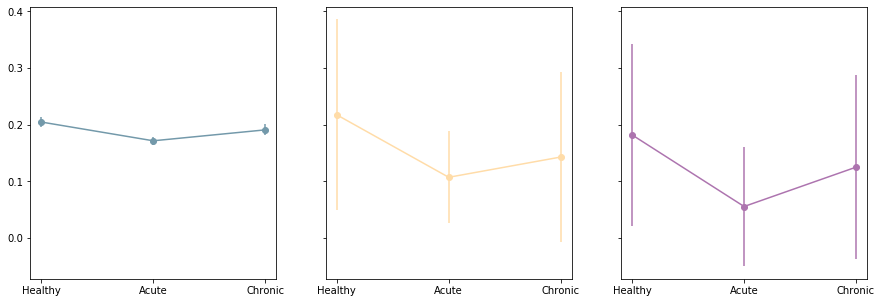

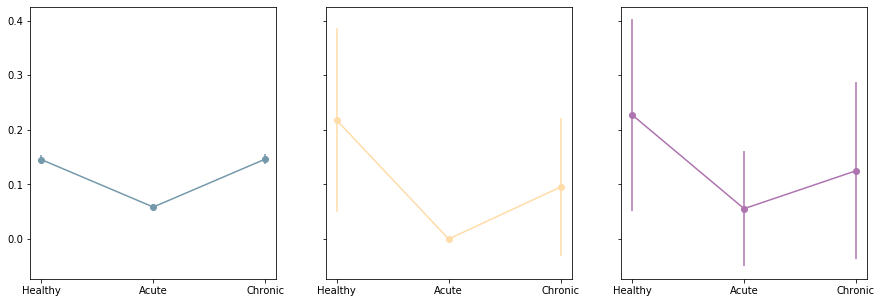

In [24]:
#Figure 3E
%matplotlib inline
df= dfC.copy()
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Acute', 'Chronic'])

fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').care.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = Colors[cond[idx]])
#     print(df2)
    del df2
fig.savefig(figFolder+'figure3F_mvmt.svg',transparent=True)

fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care_rot.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care_rot.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').care_rot.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = Colors[cond[idx]])
#     print(df2)
    del df2
fig.savefig(figFolder+'figure3F_rot.svg',transparent=True)

N = 2
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care','care_rot']:
    for cell in df.CellType.unique():
        print('--------------------------------')
        print(sig,cell)
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(period,pvalue, pvalue<0.05/(N)," ",dfComp[dfComp[sig] == True][sig].count(),'/' ,dfComp[sig].count())
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)


<h3>Figure 4</h3>

In [ ]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m][sess]['Pre']['freq'][:]
            coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            tempDict['all'] = np.nanmean(Hs2.T,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (coeff[(Himvmt ==1),:])
                Hs = np.nansum(sessH, axis=1)
                Hs2 = sessH.T/Hs.T
                tempDict[mv] = np.nanmean(Hs2.T,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

        

In [ ]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for sess in specs.keys():
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all','rot']:
        try:
            
            df2 = pd.DataFrame({'Period':specs[sess]['period'],'Mouse':specs[sess]['mouse'],'mvmt':mv,'sess':sess,
                                'beta':np.nanmean(specs[sess][mv][0,beta],axis=0),
                               'gamma':np.nanmean(specs[sess][mv][0,gamma],axis=0),
                               'highGamma':np.nanmean(specs[sess][mv][0,highGamma],axis=0),
                               'betaSum':np.nansum(specs[sess][mv][0,beta],axis=0),
                               'highGammaSum':np.nansum(specs[sess][mv][0,highGamma],axis=0),
                               'gammaSum':np.nansum(specs[sess][mv][0,gamma],axis=0)},index=[0])
            df = pd.concat([df,df2])
        except: 
            print(sess,mv)

df.to_csv(figFolder+'lfpForR.csv')
df.head()

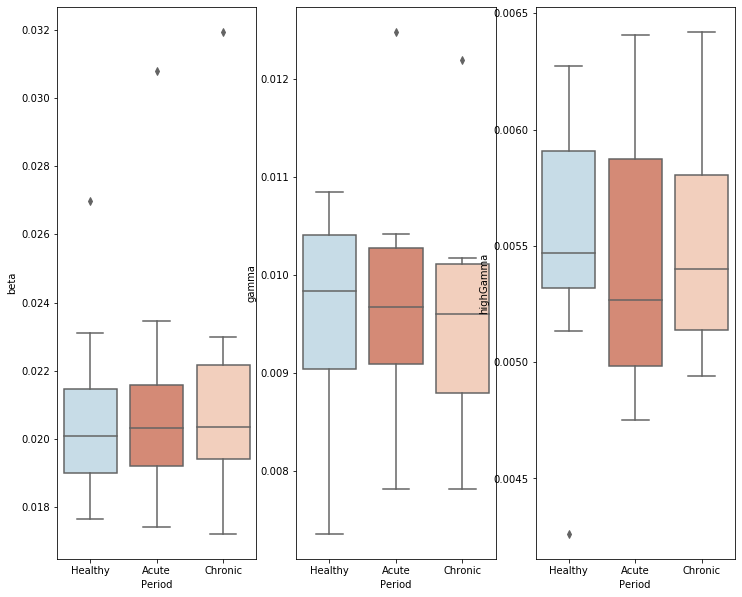

In [83]:
#Figure 4Aiii
df = pd.read_csv(figFolder+'lfpForR.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()
fig, ax = plt.subplots(1,3,figsize=(12.15,10.15))
with sns.color_palette(colorPallet3):
    sns.boxplot(x='Period',y='beta',ax = ax[0],data=df2[df2.mvmt=='all'],order = ['Healthy','Acute','Chronic'])
    sns.boxplot(x='Period',y='gamma',ax = ax[1],data=df2[df2.mvmt=='all'],order = ['Healthy','Acute','Chronic'])
    sns.boxplot(x='Period',y='highGamma',ax = ax[2],data=df2[df2.mvmt=='all'],order = ['Healthy','Acute','Chronic'])
#fig.savefig(figFolder+'figure5_lfpfullSess_bar.svg',transparent=True,format='svg')


<IPython.core.display.Javascript object>


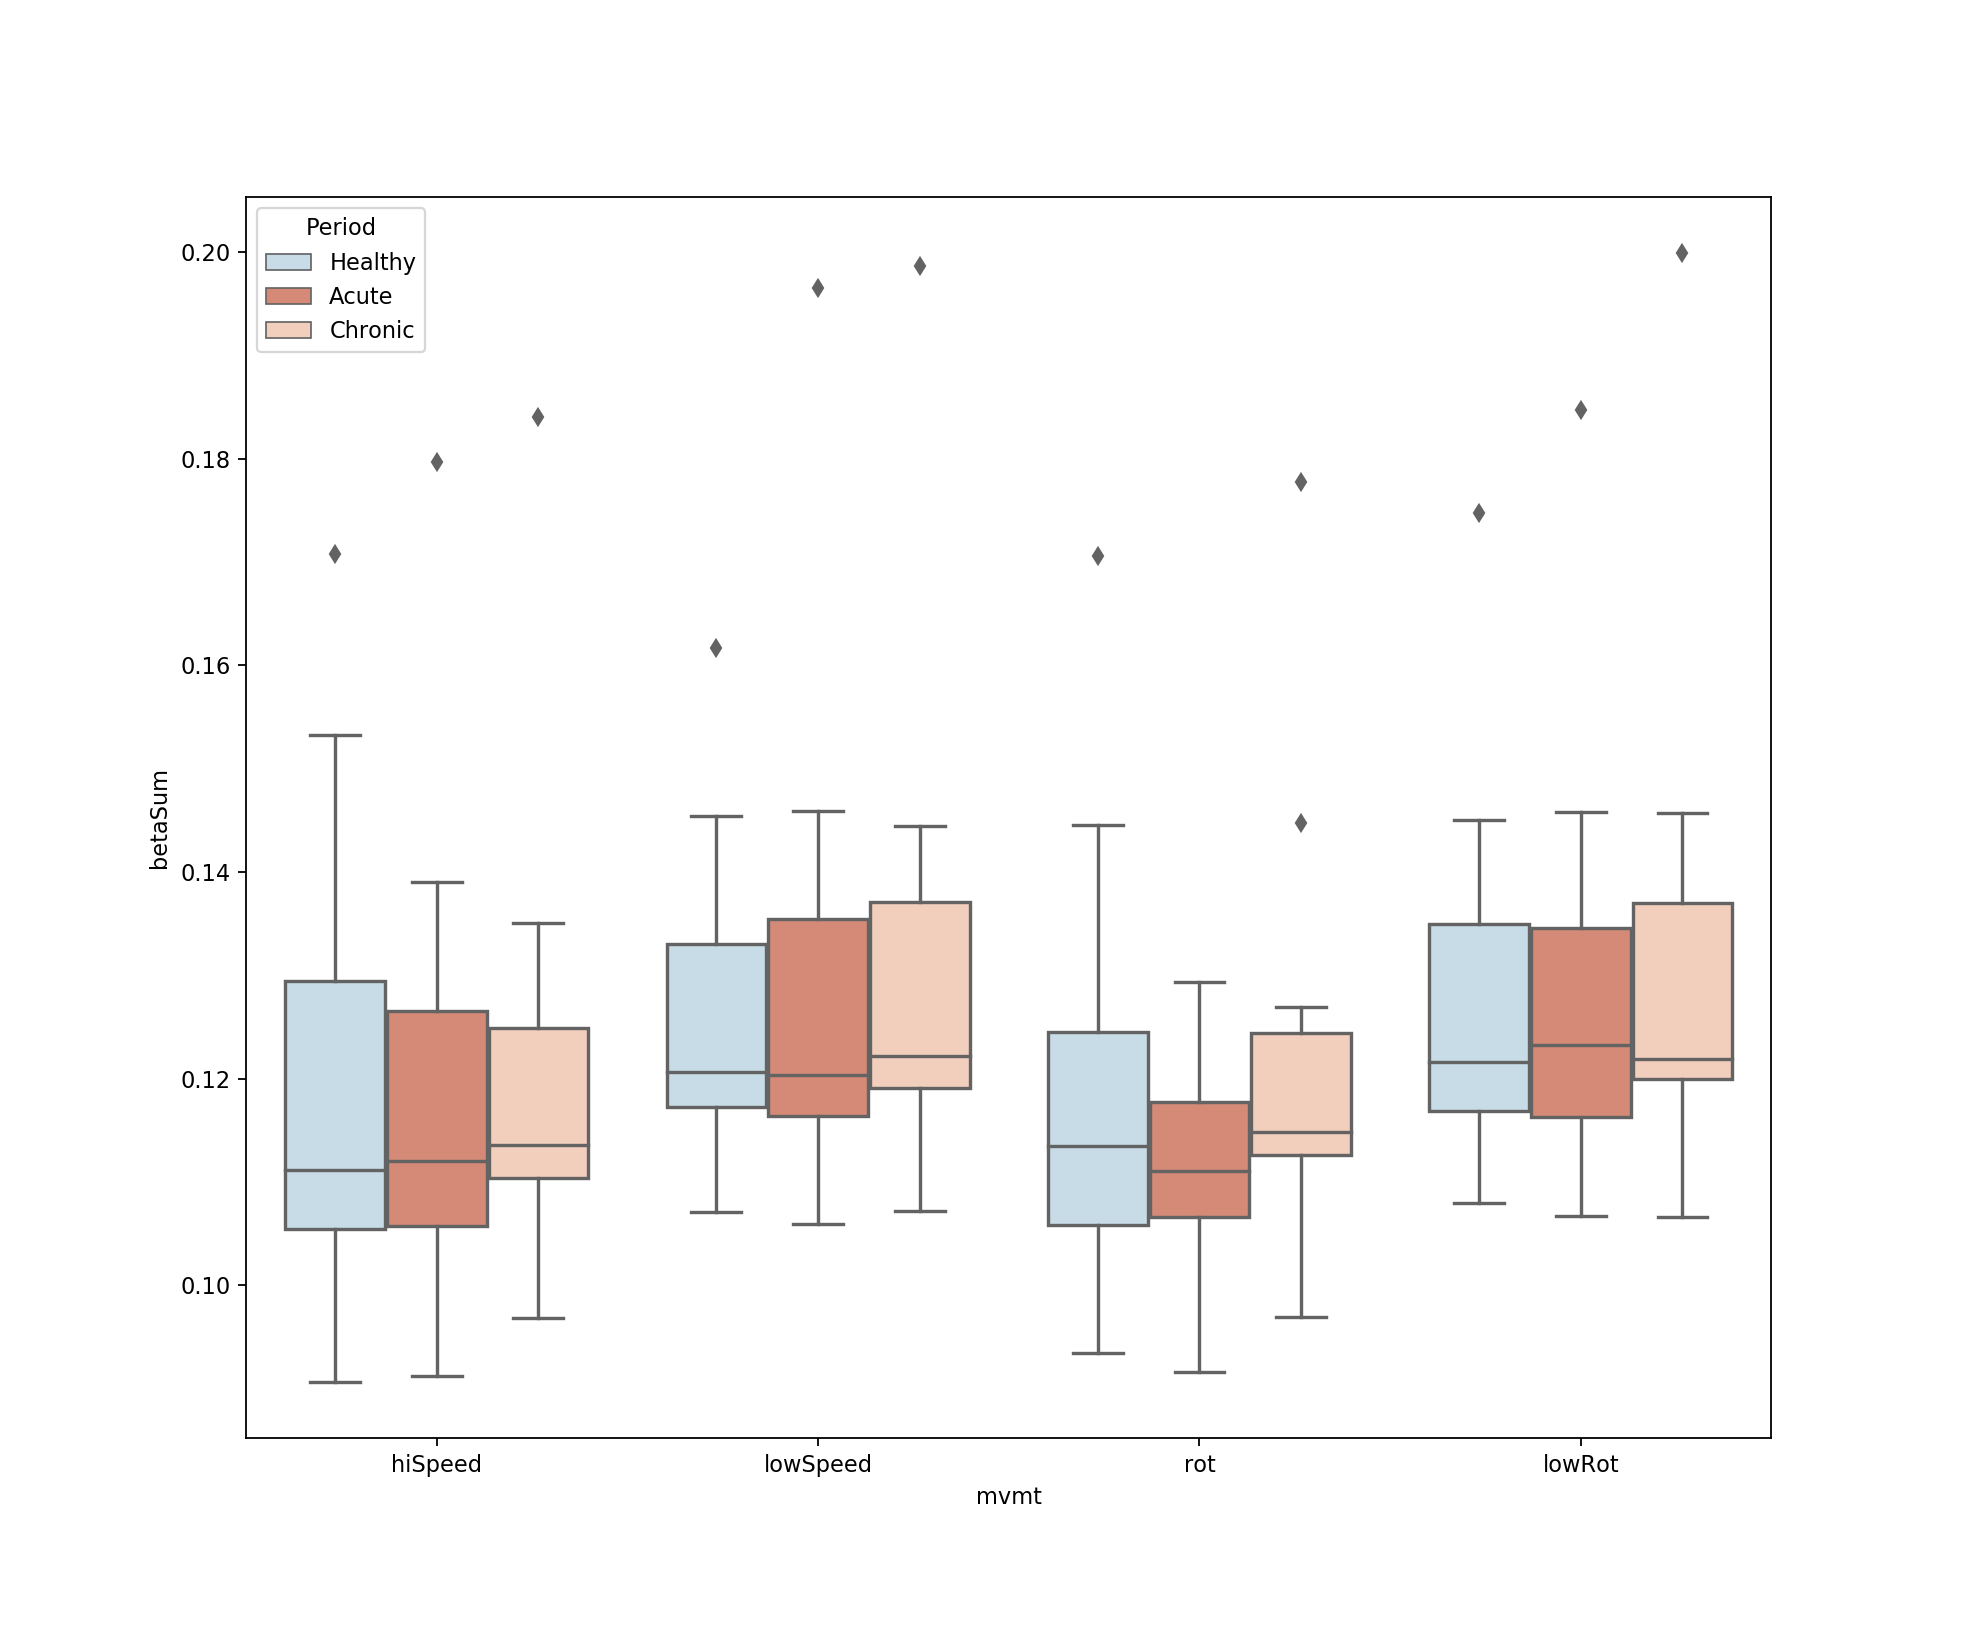

In [47]:
#Figure 4C
df = pd.read_csv(figFolder+'lfpForR.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()

fig, ax = plt.subplots(1,1,figsize=(12.15,10.15))
with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',hue = 'mvmt',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax,data=df2[df2.mvmt != 'all'],
                hue_order = ['Healthy','Acute','Chronic'],
               order = ['hiSpeed','lowSpeed','rot','lowRot'])
#fig.savefig(figFolder+'figure5C_bar_beta.svg',transparent=True,format='svg')



In [ ]:
periods = {'Healthy':{'axis':0},'Acute':{'axis':1},'Chronic':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
for sess in specs.keys():
    for c in conds:
        try:
            periods[specs[sess]['period']][c] = np.concatenate((periods[specs[sess]['period']][c],
                                                                   specs[sess][c].T),axis=1)
        except:
            print(sess,c)
            continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]

<IPython.core.display.Javascript object>


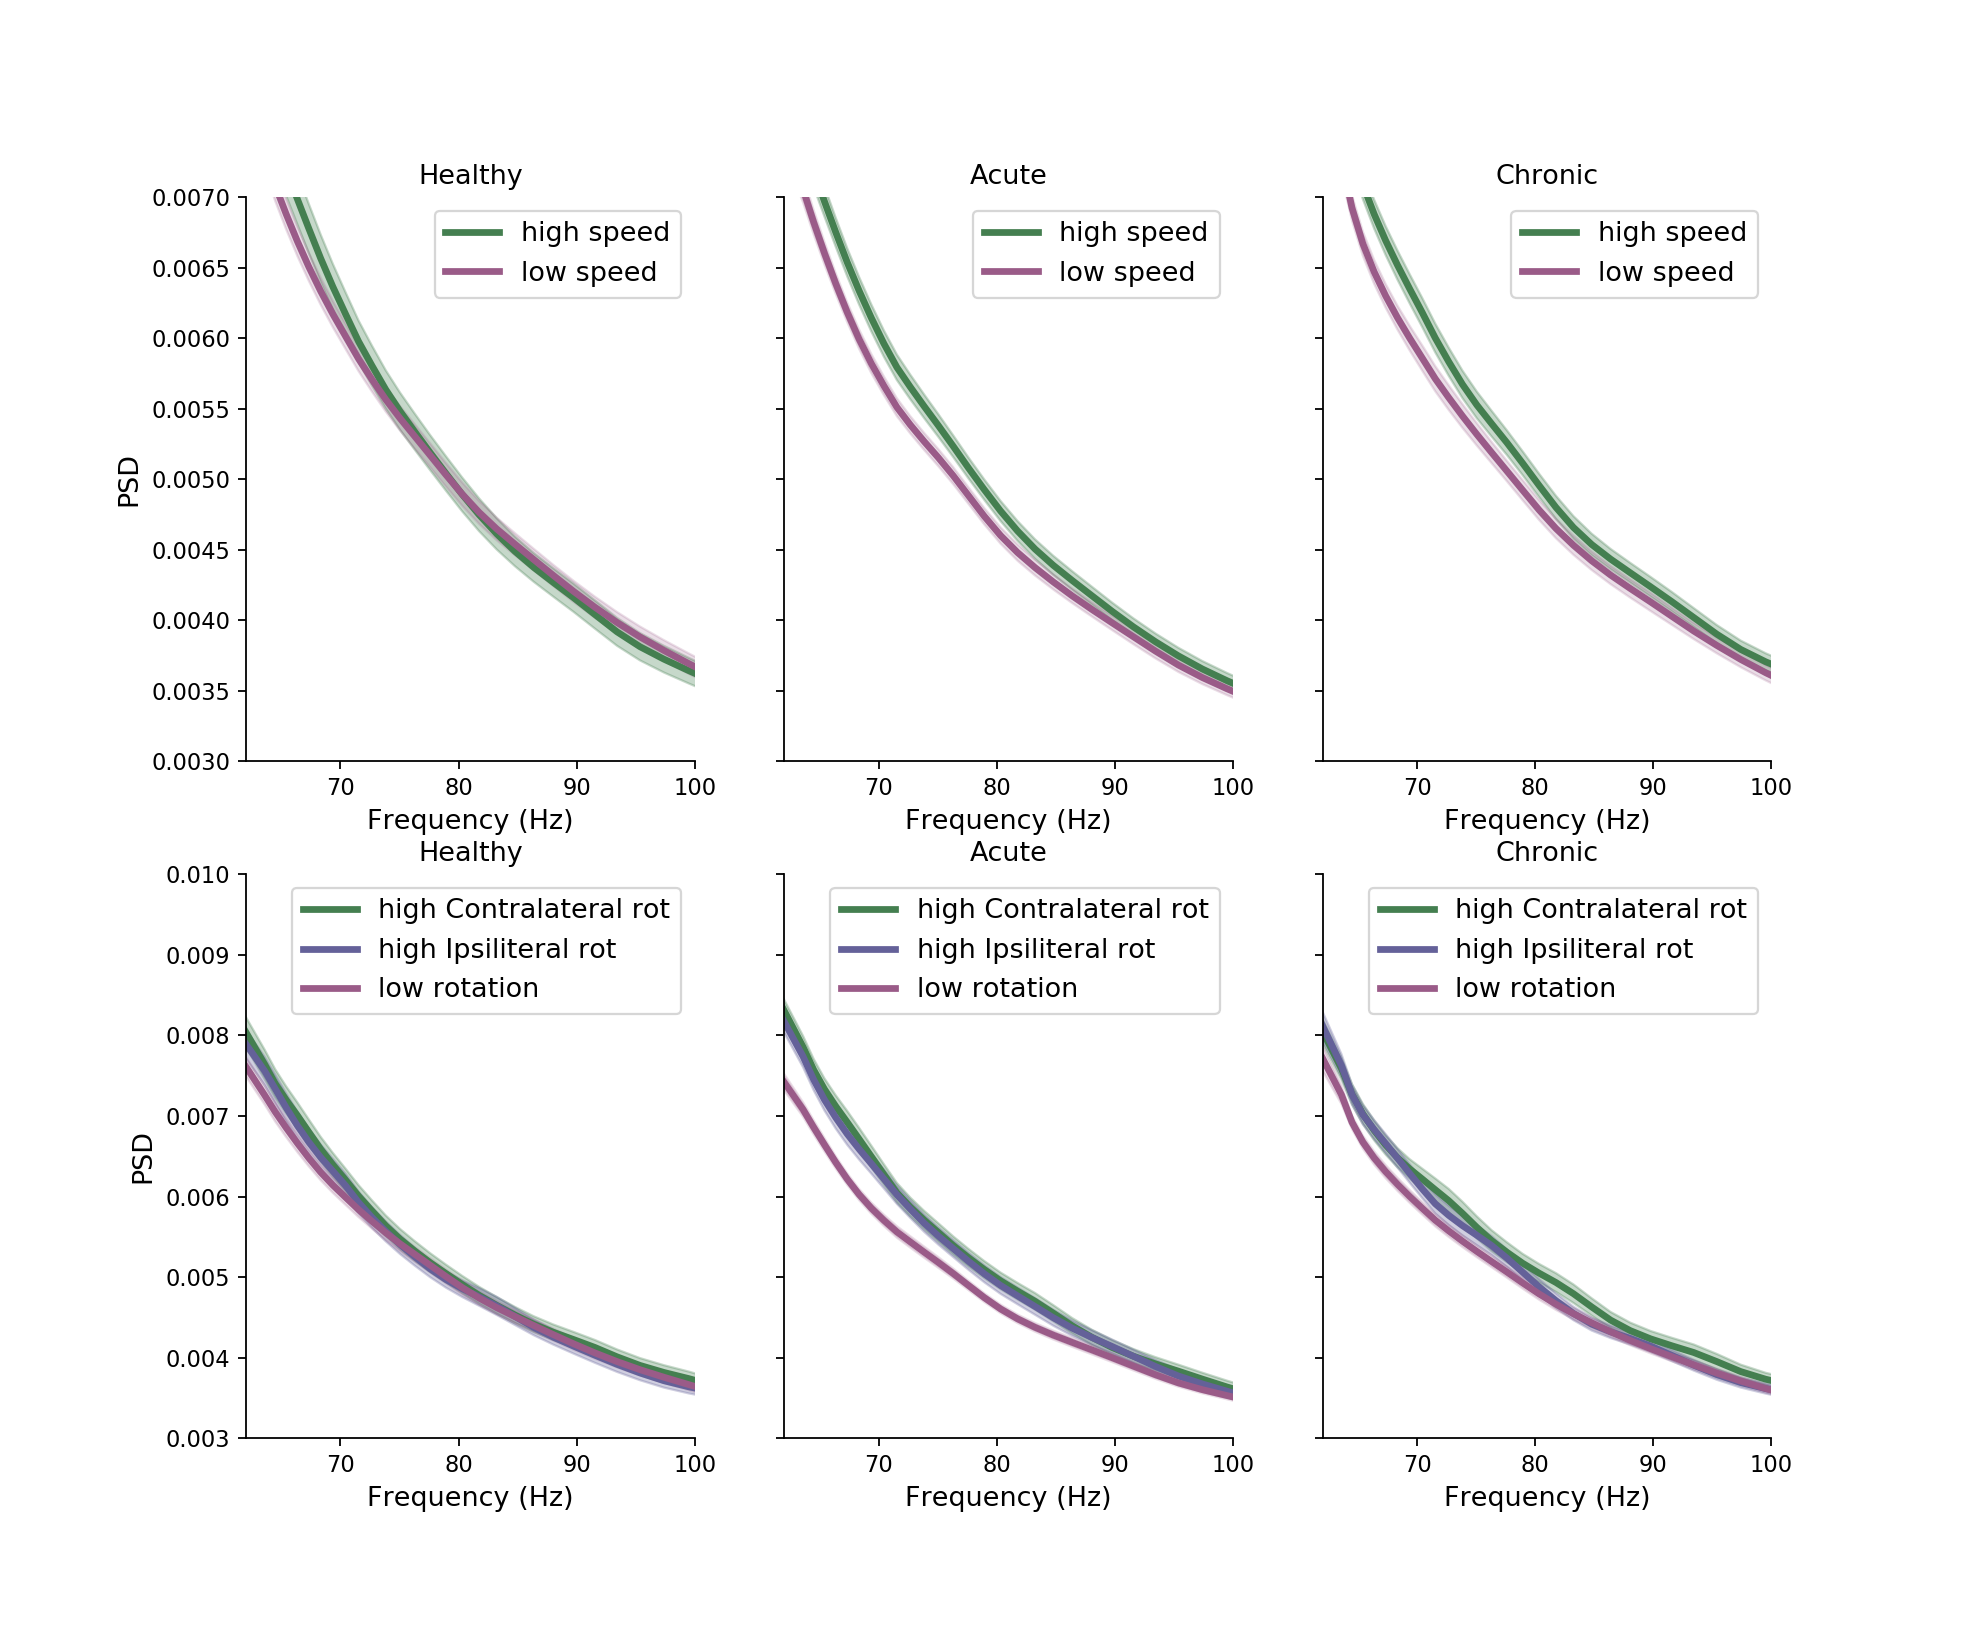

In [31]:
# Figure 4B
%matplotlib notebook
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(2,3,figsize=(12.15,10.15),sharey='row')
f60 = (freq<=58) | (freq>=63)
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['hiSpeed'],axis=1) 
    hS2 = np.nanstd(periods[p]['hiSpeed'],axis=1)/np.sqrt(periods[p]['hiSpeed'].shape[1])   
    lC = np.nanmean(periods[p]['lowSpeed'],axis=1)
    lS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)/np.sqrt(periods[p]['lowSpeed'].shape[1])
    hC = hC[f60]
    hS2=hS2[f60]
    lC = lC[f60]
    lS2 = lS2[f60]
       
    ax[0,ind].plot(freq[f60],hC,color = colorsH[4], label='high speed',linewidth=3.0)
    ax[0,ind].fill_between(freq[f60], hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[0,ind].plot(freq[f60],lC,color = colorsL[4], label='low speed',linewidth=3.0)
    ax[0,ind].fill_between(freq[f60], lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[0,ind].set_xlim(6,100)
#     ax[0,ind].set_yscale('log')
    ax[0,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[0,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[0,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[0,ind].spines['right'].set_visible(False)
    ax[0,ind].spines['top'].set_visible(False)
    ax[0,ind].legend(fontsize=12)
    
    hC = np.nanmean(periods[p]['highC'],axis=1)
    hS2 = np.nanstd(periods[p]['highC'],axis=1)/np.sqrt(periods[p]['highC'].shape[1])
    hAC = np.nanmean(periods[p]['highAC'],axis=1)
    hS2A = np.nanstd(periods[p]['highAC'],axis=1)/np.sqrt(periods[p]['highAC'].shape[1])
    lC = np.nanmean(periods[p]['lowRot'],axis=1)
    lS2 = np.nanstd(periods[p]['lowRot'],axis=1)/np.sqrt(periods[p]['lowRot'].shape[1])
    hC = hC[f60]
    hS2=hS2[f60]
    hAC = hAC[f60]
    hS2A=hS2A[f60]
    lC = lC[f60]
    lS2 = lS2[f60]

       
    ax[1,ind].plot(freq[f60],hC,color = colorsH[4], label='high Contralateral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[1,ind].plot(freq[f60],hAC,color = colorsH2[4], label='high Ipsiliteral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], hAC-hS2A, hAC+hS2A,color=colorsH2[4],alpha=0.3)
    ax[1,ind].plot(freq[f60],lC,color = colorsL[4], label='low rotation',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[1,ind].set_xlim(6,100)
#     ax[1,ind].set_yscale('log')
    ax[1,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[1,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[1,ind].spines['right'].set_visible(False)
    ax[1,ind].spines['top'].set_visible(False)
    ax[1,ind].legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPeriod.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_lfpSpectromPeriod.svg',transparent=True,format='svg')

# fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(9,17)
    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,ind].set_xlim(9,17)
    ax[1,ind].set_ylim(0.015,0.03)
#     ax[0,ind].set_ylim(0,0.032)
#     ax[1,ind].set_ylim(0,0.032)
#fig.savefig(figFolder+'lfpSpectromPeriodZoomBeta.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_ZoomBeta.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(40,60)
    ax[0,ind].set_ylim(0.008,0.012)
    ax[1,ind].set_xlim(40,60)
    ax[1,ind].set_ylim(0.008,0.012)
#     ax[0,ind].set_ylim(0,0.02)
#     ax[1,ind].set_ylim(0,0.02)
fig.savefig(figFolder+'lfpSpectromPeriodZoomGamma.svg',transparent=True,format='svg')
# fig.savefig(figFolder+'figure5_lfpZoomGamma_log.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_yscale('log')
#     ax[1,ind].set_yscale('log')
    ax[0,ind].set_xlim(62,100)
    ax[1,ind].set_xlim(62,100)
    ax[0,ind].set_ylim(0.003,0.007)
    ax[1,ind].set_ylim(0.003,0.01)
fig.savefig(figFolder+'lfpSpectromPeriodZoomHighGamma.svg',transparent=True,format='svg')



<h3> Figure 5 </h3>

In [42]:
# look at individual CHI/PV
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','a')
numshifts = 1000
for m in tqdm(miceList):
    grp = f.create_group(m)
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess in grp.keys():
            continue
        subgrp = grp.create_group(sess)
        
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 
        
        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)

        try:  
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            dff = data[sess]['trace']['dff']        
            cor3 = np.corrcoef(dff)

            ssubgrp = subgrp.create_group('Pre')
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
        except:
            print(sess)
f.close()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [2:55:35<00:00, 658.45s/it]


In [ ]:
# only run once... Also, only Asymm 
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')
col_names = ['Mouse','Sess','Day','numred','Period','population','aSymCorr','sASymCorr']
df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
df = pd.DataFrame(columns = col_names)
for m in tqdm(f.keys()):
    for sess in f[m].keys():
        try:
            numred = f[m][sess].attrs['numRed']
            cre = getCreType(Files[1],m)
            tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

            c = f[m][sess]['Pre']['pearson'].value 
            c[(np.tril(np.ones(c.shape),-1))==0] = np.nan

            d = f[m][sess]['Pre'][('pearson_shuffle')].value
            b = np.nanpercentile(d,[97.5,2.5],axis=2)

            d = np.nanmean(d,axis=2)
            d[np.tril(np.ones(d.shape),-1)==0] = np.nan

            nSig = (c>b[0,:,:])|(c<b[1,:,:])
            cSig = np.copy(c)
            cSig[~nSig] = np.nan
            noSig = np.copy(c)
            noSig[nSig] = np.nan

            if numred > 1:
                tempDict['population'] = cre+'-'+cre
                tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
                tempDict['sigPercent'] = np.nansum(nSig[:numred,:numred]==1)/np.nansum(np.isnan(c[:numred,:numred])==0)
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            if numred > 0:
                tempDict['population'] = 'MSN-'+cre
                tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
                tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)
                
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
#                 hi,bi = np.histogram(c[numred:,:numred],np.arange(-1,1,0.01))
#                 hi2,bi2 = np.histogram(cSig[numred:,:numred],np.arange(-1,1,0.01))
#                 df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                 'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                   'population':'MSN-'+cre,'mvmt':'all','values':hi,'values_sig':hi2},ignore_index=True)


            tempDict['population'] = 'MSN-MSN'
            tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
            tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
            tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
            tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
            tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
            df2 = pd.DataFrame([tempDict])
            df = pd.concat([df,df2],sort=True)
#             hi,bi = np.histogram(c[numred:,numred:],np.arange(-1,1,0.01))
#             hi2,bi2 = np.histogram(cSig[numred:,numred:],np.arange(-1,1,0.01))
#             df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                             'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                               'population':'MSN-MSN','mvmt':'all','values':hi,'values_sig':hi2},ignore_index=True)

        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,  exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'bySessCompareCorr2Sig3.csv')
# df3.to_csv(figFolder+'bySessCompareCorr2Sig_hists.csv')

2980_BaselineS (169,)
(148, 148)
2980_day30A (133,)
(102, 102)


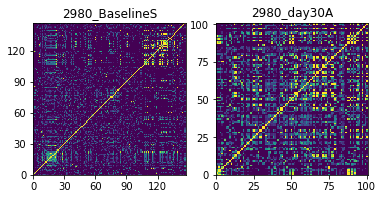

In [62]:
#Figure 5A 
from matplotlib.ticker import MaxNLocator
m = '2980'
sessions = ['2980_BaselineS','2980_day30A']
f = h5py.File('J:\\connactivityAnalysis\\connMaps2.hdf5','r')
ind = 0
fig, ax = plt.subplots(1,2)
for sess in sessions:    
    if f[m][sess].attrs['day'] in [0,30,31,32,34,35,36]:
        c = f[m][sess]['Pre']['aSymCorr'].value 
        a = ~np.isnan(c).all(axis=0)
        print(sess,a.shape)
        c = c[a,:][:,a]
        print(c.shape)
#         print(sess,c.shape)
#         c = c[~np.isnan(c).all(axis=0)]
# #         c = c[~np.isnan(c).any(axis=0)]
#         print(sess,c.shape)
        ax[ind].set_aspect('equal', adjustable='box')
        CS = ax[ind].pcolormesh(np.arange(c.shape[0]),np.arange(c.shape[0]),c.T,
                                vmax=.4, vmin = 0,rasterized = True)
        ax[ind].set_title(sess)
        ax[ind].set_aspect('equal', adjustable='box')
        ax[ind].yaxis.set_major_locator(MaxNLocator(5))
        ax[ind].xaxis.set_major_locator(MaxNLocator(5))
        ind = ind+1
f.close()
# fig.colorbar(CS)
fig.savefig(figFolder+'figure4_example_nocolorBar.svg',transparent=True)

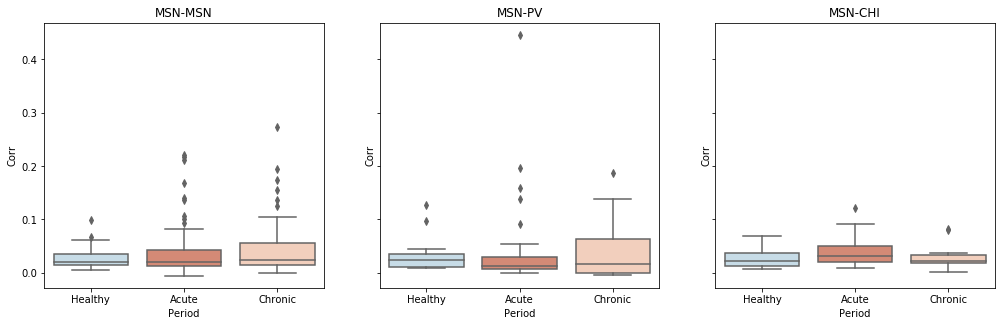

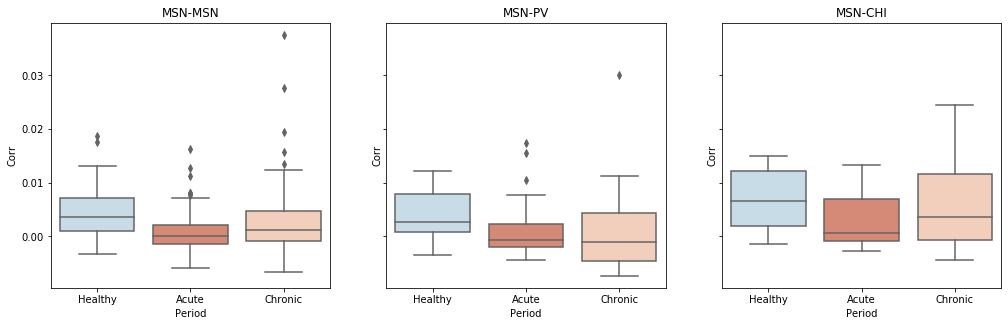

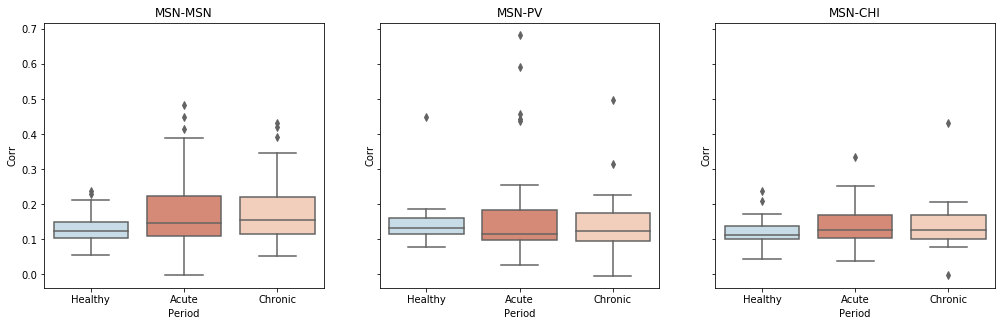

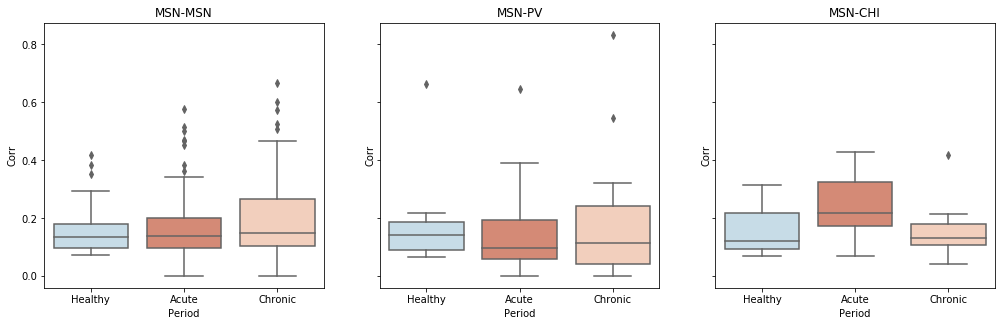

In [37]:
#Figure 4B-D + S4A-B
df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig.csv')

df2 = df.melt(id_vars = ['Mouse','Period','population'],value_vars=["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)
pOrder = ['Healthy', 'Acute', 'Chronic']

for col in ["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"]:
    fig, ax = plt.subplots(1,3,figsize=(17.04,4.88), sharey=True)
    with sns.color_palette(colorPallet3):
        g = sns.boxplot(x="Period", y="Corr", ax = ax[0], data=df2[(df2.population=='MSN-MSN')&(df2.varType==col)],
                        order = pOrder, showfliers = True)
        ax[0].set_title('MSN-MSN')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[1], data=df2[(df2.population=='MSN-PV')&(df2.varType==col)],
                        order =  pOrder, showfliers = True)
        ax[1].set_title('MSN-PV')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[2], data=df2[(df2.population=='MSN-CHI')&(df2.varType==col)],
                        order =  pOrder, showfliers = True)
        ax[2].set_title('MSN-CHI')
    #g = sns.boxplot(x="Period", y="Corr", hue="varType", data=df2[(df2.population=='MSN-MSN')&(df2.varType=='personF')], order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
#     ax[0].set_ylim(-0.01,0.25)
#     fig.savefig(figFolder+'figure4a_3_'+col+'.svg',transparent=True)


In [44]:
Pdf = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig.csv')
df = pd.read_csv(figFolder+ 'rotation_forR.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess',"percent_low":'lowRot'})
df['highRot'] = df.apply(lambda x: (x.percent_high_C+x.percent_high_AC), axis=1)
df2 = pd.merge(Pdf,df[['Sess','Period','percent_high_C','percent_high_AC','lowRot','highRot']],on=['Sess','Period'])
df = pd.read_csv('D:\\6OHDA\\submission2\\speedData.csv')
df = df.groupby(['Session','Period']).mean()
df = df.reset_index()
df = df.rename(columns={"Session":'Sess',"percent_high":'highSpeed',"percent_low":"lowSpeed"})
df2 = pd.merge(df2,df[['Sess','Period','highSpeed','lowSpeed']],on=['Sess','Period'])
df2

,Unnamed: 0,Day,Mouse,Period,Sess,aSymCorr,aSymCorrNotSig,aSymCorrSig,numred,personF,population,sASymCorr,sPersonF,sigPercent,percent_high_C,percent_high_AC,lowRot,highRot,highSpeed,lowSpeed
0,0,0,761,Healthy,0761_BaselineA,0.016887,0.003606,0.149698,1,NaN,MSN-CHI,-0.000093,NaN,0.090909,0.042104,0.115976,0.657534,0.158081,0.053534,0.797294
1,0,0,761,Healthy,0761_BaselineA,0.021118,0.000154,0.164875,1,NaN,MSN-MSN,-0.000166,NaN,0.127273,0.042104,0.115976,0.657534,0.158081,0.053534,0.797294
2,0,0,761,Healthy,0761_BaselineL,0.069546,0.006671,0.207870,1,NaN,MSN-CHI,-0.000635,NaN,0.312500,0.030759,0.178418,0.635936,0.209177,0.097235,0.725523
3,0,0,761,Healthy,0761_BaselineL,0.056678,0.007323,0.218843,1,NaN,MSN-MSN,-0.000036,NaN,0.233333,0.030759,0.178418,0.635936,0.209177,0.097235,0.725523
4,0,0,761,Healthy,0761_BaselineS,0.048253,0.011056,0.154531,1,NaN,MSN-CHI,-0.000287,NaN,0.259259,0.067233,0.178839,0.470628,0.246071,0.114800,0.584839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0,6,8815,Acute,8815_day6,NaN,NaN,NaN,4,NaN,MSN-CHI,NaN,NaN,NaN,0.000000,0.080138,0.758369,0.080138,0.240415,0.736301
418,0,6,8815,Acute,8815_day6,0.081291,-0.003170,0.376904,4,NaN,MSN-MSN,0.000054,NaN,0.222222,0.000000,0.080138,0.758369,0.080138,0.240415,0.736301
419,0,8,8815,Acute,8815_day8,NaN,NaN,NaN,3,NaN,CHI-CHI,NaN,NaN,NaN,0.043866,0.067815,0.514286,0.111681,0.387143,0.509664
420,0,8,8815,Acute,8815_day8,0.090898,-0.000171,0.195824,3,NaN,MSN-CHI,0.000011,NaN,0.464646,0.043866,0.067815,0.514286,0.111681,0.387143,0.509664


<IPython.core.display.Javascript object>


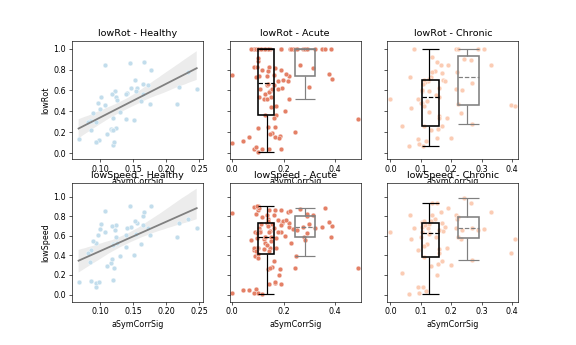

----------------------------------------------------------------
lowRot (0.29373696403830757, 1.584178588816447e-05) 0.086281404042442 0.08186730454506252
lowRot 0.13271171072384744 0.04017237646745469
Healthy Acute 72.0
Pathalogical Acute 25.0
Healthy Chronic 45.0
Pathalogical Chronic 16.0
----------------------------------------------------------------
lowSpeed (0.2650423718157472, 0.00010519697156652465) 0.07024745885771688 0.06575590068794734
lowSpeed 0.13271171072384744 0.04017237646745469
Healthy Acute 72.0
Pathalogical Acute 25.0
Healthy Chronic 45.0
Pathalogical Chronic 16.0


In [45]:
# Figure 4E
%matplotlib notebook
col = 'aSymCorrSig'
#col2  = 'percent_high_C'
fig, ax = plt.subplots(2,3,figsize=(10,6),sharey='row')
for indp,col2 in enumerate(['lowRot','lowSpeed']):
    df3 = df2[df2.population == 'MSN-MSN']
#     df3[col] = df3.apply(lambda x: x[col]/df2[(df2.Period=='Healthy')&(df2.Mouse==x.Mouse)][col].mean(),axis=1 )
#     df3[col2] = df3.apply(lambda x: x[col2]/df2[(df2.Period=='Healthy')&(df2.Mouse==x.Mouse)][col2].mean(),axis=1 )
#     df3 = df3[(df3.Period=='Healthy')]
#     sns.regplot(x=col,y=col2,data = df3,color='k',marker=".",ax=ax[indp,0])
#     sns.scatterplot(x=col,y=col2,hue = 'Period',data = df3,palette=colorPallet3,ax=ax[indp,0])
#     ax[indp].set_ylim(-1.1,1.1)
#     ax[indp,0].set_title(col2+ ' - All')
#     sns.jointplot(x=col,y=col2,data = df3,hue = 'Period')#, kind="reg")
    df4 = df3[[col,col2]].dropna()
    df4['Intercept']=1
    model = sm.OLS(df4[col2], df4[['Intercept',col]])
    model_results = model.fit()
    b = model_results.params
    a =np.sum(b*df4[['Intercept',col]],axis=1)
    
    print ('----------------------------------------------------------------')
    print(col2,sci.stats.pearsonr(df4[col],df4[col2]),model_results.rsquared,model_results.rsquared_adj)
    df4 = df3[df3.Period == 'Healthy'][[col,col2]].dropna()
    Hrange = np.mean(df4[col])+2*np.std(df4[col])
    print(col2, np.mean(df4[col]),np.std(df4[col]))
    for iPer,per in enumerate(df3.Period.unique()):
        if per != 'Healthy':
            df4 = df3[(df3.Period == per)][[col,col2]].dropna()
            df4['binBox'] = pd.cut(df4[col],[0,Hrange,np.max(df4[col])+0.001],labels=['Healthy','Pathalogical'])
            df5 = df4.groupby('binBox').describe()
            for b in ['Healthy','Pathalogical']:
                if b == 'Healthy':
                    color = 'k'
                else:
                    color = 'grey'  
                print(b,per,df5.loc[b][col].loc['count'])
                Q1_1 = df5.loc[b][col].loc['25%']
                Q3_1 = df5.loc[b][col].loc['75%']
                IQR_1 = Q3_1-Q1_1
                Q1_2 = df5.loc[b][col2].loc['25%']
                Q3_2 = df5.loc[b][col2].loc['75%']
                IQR_2 = Q3_2-Q1_2
        
                ax[indp,iPer].add_patch(Rectangle((Q1_1,Q1_2),IQR_1,IQR_2,facecolor="none", ec=color, lw=2))
                ax[indp,iPer].hlines(df5.loc[b][col2].loc['50%'],Q1_1,Q3_1,color=color,linestyles='dashed')
                
                no_outliers = df4[df4.binBox==b][col2][(Q1_2 - 1.5*IQR_2 < df4[df4.binBox==b][col2]) &  (df4[df4.binBox==b][col2] < Q3_2 + 1.5*IQR_2)]
                ax[indp,iPer].vlines(df5.loc[b][col].loc['50%'],np.min(no_outliers),Q1_2,color=color)
                ax[indp,iPer].vlines(df5.loc[b][col].loc['50%'],Q3_2,np.max(no_outliers),color=color)
                ax[indp,iPer].hlines(np.min(no_outliers),Q1_1,Q3_1,color=color) 
                ax[indp,iPer].hlines(np.max(no_outliers),Q1_1,Q3_1,color=color) 
                
                no_outliers = df4[df4.binBox==b][col][(Q1_1 - 1.5*IQR_1 < df4[df4.binBox==b][col]) &  (df4[df4.binBox==b][col] < Q3_1 + 1.5*IQR_1)]
                ax[indp,iPer].vlines(df5.loc[b][col2].loc['50%'],Q1_1,Q3_1,color=color,linestyles='dashed')

                #                 ax[indp,iPer].hlines(df5.loc[b][col2].loc['50%'],np.min(no_outliers),np.max(no_outliers),color=color,linestyles='dashed')
#                 ax[indp,iPer].hlines(df5.loc[b][col2].loc['50%'],np.min(no_outliers),Q1_1,color=color)
#                 ax[indp,iPer].hlines(df5.loc[b][col2].loc['50%'],Q3_1,np.max(no_outliers),color=color)
#                 ax[indp,iPer].vlines(np.min(no_outliers),Q1_2,Q3_2,color=color) 
#                 ax[indp,iPer].vlines(np.max(no_outliers),Q1_2,Q3_2,color=color) 
                                                    
        else: 
            sns.regplot(x=col,y=col2,data = df3[(df3.Period == per)],color='gray',marker=".",ax=ax[indp,iPer])
        sns.scatterplot(x=col,y=col2,data = df3[df3.Period == per],color=colorPallet3[iPer,:],ax=ax[indp,iPer])
        ax[indp,iPer].set_title(col2 + ' - '+per)
        ax[indp,iPer].set_xlim([np.min(df4[col])-0.01,np.max(df4[col])+0.01])
        ax[indp,iPer].errorbar
#         df4['Intercept']=1
#         model = sm.OLS(df4[col2], df4[['Intercept',col]])
#         model_results = model.fit()
#         b = model_results.params
#         a =np.sum(b*df4[['Intercept',col]],axis=1)
#         print(per,':')
#         print(col2,sci.stats.pearsonr(df4[col],df4[col2]),model_results.rsquared,model_results.rsquared_adj)
# fig.savefig(figFolder+'new4E.svg',transparent=True)

<h3> Figure 6 </h3>

In [45]:
# Recalculate the LFP align to MSN onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2ca_notNormalize\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])


        if os.path.exists(savePath+'MSN\\'+sess):
            df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
            continue

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE\\"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN\\"+sess, "wb" ) , protocol=4)
            del aligned

df.to_csv(savePath+'sessions')


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12


 46%|█████████████████████████████████████▊                                            | 6/13 [17:14<16:54, 144.99s/it]

found  17.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [07:22<03:46, 45.33s/it]

found  888231.0  outlier points


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [09:53<05:08, 77.16s/it]

found  481139.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [04:43<00:20, 20.70s/it]

found  3.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 43%|███████████████████████████████████▌                                               | 6/14 [06:45<08:19, 62.50s/it]

found  50.0  outlier points


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 21%|█████████████████▎                                                                | 4/19 [14:25<45:15, 181.03s/it]

found  29.0  outlier points


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [07:20<00:00, 31.46s/it]


In [46]:
# Recalculate the LFP align to MSN onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2ca_notNormalize\\Post\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Post', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])

        if sess[-1] == 'A':
            drug = 'Amph'
        elif sess[-1]=='L':
            drug  = 'L-Dopa'
        else:
            drug = 'Saline'

        if os.path.exists(savePath+'MSN\\'+sess):
            df.append({'mouse':m,'sess':sess,'day':day,'drug':drug,
                       'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
            continue

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Post','caOnset_Hf')
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Post']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE\\"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN\\"+sess, "wb" ) , protocol=4)
            del aligned
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'drug':drug,
                       'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up lfp data


 57%|███████████████████████████████████████████████▍                                   | 4/7 [20:59<13:24, 268.08s/it]

found  3.0  outlier points


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [25:30<03:15, 195.80s/it]

found  2.0  outlier points


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up lfp data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
cleaning up lfp data
found  34.0  outlier points


 71%|████████████████████████████████████████████████████████████                        | 5/7 [06:24<02:32, 76.21s/it]

found  927582.0  outlier points


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [08:25<01:29, 89.71s/it]

found  447664.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8
cleaning up lfp data


 43%|████████████████████████████████████                                                | 3/7 [05:24<06:29, 97.45s/it]

found  144.0  outlier points


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8
cleaning up lfp data


 43%|████████████████████████████████████                                                | 3/7 [04:41<05:52, 88.10s/it]

found  105.0  outlier points


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 4539_day0
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9
cleaning up lfp data


 50%|█████████████████████████████████████████▌                                         | 2/4 [08:39<06:29, 194.69s/it]

found  17.0  outlier points


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session: 7584_day12
I deleted session: 7584_day15
I deleted session: 7584_day2
I deleted session: 7584_day3
I deleted session: 7584_day4
I deleted session: 7584_day5
I deleted session: 7584_day6
I deleted session: 7584_day7
I deleted session: 7584_day8
I deleted session: 7584_day9
cleaning up lfp data


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9
cleaning up lfp data
found  10.0  outlier points


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9
cleaning up lfp data


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8
cleaning up lfp data


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:39<00:00, 57.12s/it]


In [58]:
# Recalculate the LFP align to mvmt onset  
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2speed2\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


 46%|██████████████████████████████████████▎                                            | 6/13 [00:23<00:31,  4.49s/it]

found  17.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [01:13<00:41,  8.23s/it]

found  888231.0  outlier points


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [01:21<00:33,  8.30s/it]

found  481139.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [01:29<00:07,  7.41s/it]

found  3.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 43%|███████████████████████████████████▌                                               | 6/14 [00:47<01:01,  7.72s/it]

found  50.0  outlier points


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 21%|█████████████████▍                                                                 | 4/19 [00:29<01:52,  7.49s/it]

found  29.0  outlier points


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:45<00:00,  7.51s/it]


In [53]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\Post\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\Post\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    drug = df[df.sess==sess].drug.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPowerPost.csv')

0761_BaselineL  - CRE failed at line  21
0761_day14A  - CRE failed at line  21
0761_day14A  - MSN failed at line  59
0761_day31A  - CRE failed at line  21
1208_BaselineA  - CRE failed at line  21
1208_day19L  - CRE failed at line  21
1222_BaselineA  - CRE failed at line  21
1222_BaselineL  - CRE failed at line  21
1222_BaselineS  - CRE failed at line  21
1222_day15A  - CRE failed at line  21
1222_day20L  - CRE failed at line  21
1222_day32A  - CRE failed at line  21
1222_day32A  - MSN failed at line  59
1222_day36L  - CRE failed at line  21
1236_BaselineA  - CRE failed at line  21
1236_BaselineL  - CRE failed at line  21
1236_day19L  - CRE failed at line  21
1253_BaselineA  - CRE failed at line  21
1253_BaselineS  - CRE failed at line  21
1793_BaselineA  - CRE failed at line  21
1793_day19L  - CRE failed at line  21
1793_day30A  - CRE failed at line  21
1793_day34L  - CRE failed at line  21
2976_BaselineA  - CRE failed at line  21
2976_BaselineL  - CRE failed at line  21
2976_BaselineS

In [55]:
Pdf = pd.read_csv(figFolder+'statsForPowerPost.csv')
for cell in Pdf.CellType.unique():
    dfA = Pdf[(Pdf.CellType == cell)&(Pdf.drug == 'Amph')]
    dfL = Pdf[(Pdf.CellType == cell)&(Pdf.drug == 'L-Dopa')]
    Fa,Pa = sci.stats.mannwhitneyu(dfA[dfA.Period == 'Healthy'].high_Gamma,dfA[dfA.Period == 'Chronic'].high_Gamma)
    Fl,Pl = sci.stats.mannwhitneyu(dfL[dfL.Period == 'Healthy'].high_Gamma,dfL[dfL.Period == 'Chronic'].high_Gamma)
    print(cell,' - Amphatamine: ', Pa)
    print(cell,' - L-Dopa: ', Pl)
# Pdf.dtypes

CHI  - Amphatamine:  0.5
CHI  - L-Dopa:  0.1956336396413197
MSN  - Amphatamine:  0.17026563377142767
MSN  - L-Dopa:  0.2751067774726903
PV  - Amphatamine:  0.39209561470080956
PV  - L-Dopa:  0.36183680491588155


In [64]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'MSN'
    cre = None
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'CHI'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_CHI_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

    
    
savePath = 'J:\\lfp2speed2\\'
for per in periods.keys():
    A,df2 = getAlignedLFP_mvmt2(savePath, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_speedOnset_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



In [60]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2ca_notNormalize\\Post\\sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
    
for per in periods.keys():
    cellType = 'MSN'
    cre = None
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],drugPeriod = 'Post',drug = 'L-Dopa')
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN_Mouse_post_Ldopa'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)


In [65]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPower.csv')

0761_day1  - CRE failed at line  20
0761_day1  - MSN failed at line  58
0761_day12  - CRE failed at line  20
0761_day14A  - CRE failed at line  20
0761_day2  - CRE failed at line  20
0761_day31A  - CRE failed at line  20
0761_day4  - CRE failed at line  20
1208_BaselineA  - CRE failed at line  20
1208_day14  - CRE failed at line  20
1208_day19L  - CRE failed at line  20
1208_day4  - CRE failed at line  20
1222_BaselineA  - CRE failed at line  20
1222_day11  - CRE failed at line  20
1222_day13  - CRE failed at line  20
1222_day2  - CRE failed at line  20
1222_day20L  - CRE failed at line  20
1222_day3  - CRE failed at line  20
1222_day32A  - CRE failed at line  20
1222_day36L  - CRE failed at line  20
1222_day5  - CRE failed at line  20
1222_day7  - CRE failed at line  20
1222_day9  - CRE failed at line  20
1236_BaselineL  - CRE failed at line  20
1236_day1  - CRE failed at line  20
1236_day19L  - CRE failed at line  20
1236_day3  - CRE failed at line  20
1236_day7  - CRE failed at line

In [67]:
# add speed onset to cell onset dataframe
Pdf = pd.read_csv(figFolder+'statsForPower.csv')

periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2speed2\\sessions')
savePath = 'J:\\lfp2speed2\\'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = 'mvmt'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
        A = pickle.load(open(savePath+'/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

        
Pdf.to_csv(figFolder+'statsForPower.csv')

In [12]:
# plot Get statistics for Gamma Power
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = {'post':(tPlot >0.2) & (tPlot<1.2) ,'pre':(tPlot<0),'s200':(tPlot >0) & (tPlot<0.2)}
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for ti in t200.keys():
            for k in fr.keys():
                highGamma = fr[k]
                tDict[k] = np.nanmean(b[t200[ti],:][:,highGamma])
                tDict['time'] = ti
            Pdf = Pdf.append(tDict,ignore_index=True)

        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for ti in t200.keys():
            for k in fr.keys():
                highGamma = fr[k]
                tDict[k] = np.nanmean(b[t200[ti],:][:,highGamma])
                tDict['time'] = ti
            Pdf = Pdf.append(tDict,ignore_index=True)

        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPower_supplemental1.csv')

<ipython-input-12-c66e25f3abb4>:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq = f['0761']['0761_BaselineA']['Pre']['freq'].value


0761_day1  - CRE failed at line  19
0761_day1  - MSN failed at line  60
0761_day12  - CRE failed at line  19
0761_day14A  - CRE failed at line  19
0761_day2  - CRE failed at line  19
0761_day31A  - CRE failed at line  19
0761_day4  - CRE failed at line  19
1208_BaselineA  - CRE failed at line  19
1208_day14  - CRE failed at line  19
1208_day19L  - CRE failed at line  19
1208_day4  - CRE failed at line  19
1222_BaselineA  - CRE failed at line  19
1222_day11  - CRE failed at line  19
1222_day13  - CRE failed at line  19
1222_day2  - CRE failed at line  19
1222_day20L  - CRE failed at line  19
1222_day3  - CRE failed at line  19
1222_day32A  - CRE failed at line  19
1222_day36L  - CRE failed at line  19
1222_day5  - CRE failed at line  19
1222_day7  - CRE failed at line  19
1222_day9  - CRE failed at line  19
1236_BaselineL  - CRE failed at line  19
1236_day1  - CRE failed at line  19
1236_day19L  - CRE failed at line  19
1236_day3  - CRE failed at line  19
1236_day7  - CRE failed at line

<ipython-input-12-c66e25f3abb4>:42: RuntimeWarning: Mean of empty slice
  b = np.nanmean(b,axis=2)
<ipython-input-12-c66e25f3abb4>:47: RuntimeWarning: Mean of empty slice
  tDict[k] = np.nanmean(b[t200[ti],:][:,highGamma])


1793_day6  - CRE failed at line  19
2976_BaselineA  - CRE failed at line  19
2976_BaselineL  - CRE failed at line  19
2976_BaselineS  - CRE failed at line  19
2976_day10  - CRE failed at line  19
2976_day12  - CRE failed at line  19
2976_day14  - CRE failed at line  19
2976_day15A  - CRE failed at line  19
2976_day19L  - CRE failed at line  19
2976_day2  - CRE failed at line  19
2976_day30A  - CRE failed at line  19
2976_day35L  - CRE failed at line  19
2976_day6  - CRE failed at line  19
2976_day8  - CRE failed at line  19
2980_BaselineA  - CRE failed at line  19
2980_BaselineL  - CRE failed at line  19
2980_BaselineS  - CRE failed at line  19
2980_day10  - CRE failed at line  19
2980_day12  - CRE failed at line  19
2980_day14  - CRE failed at line  19
2980_day15A  - CRE failed at line  19
2980_day19L  - CRE failed at line  19
2980_day2  - CRE failed at line  19
2980_day30A  - CRE failed at line  19
2980_day35L  - CRE failed at line  19
2980_day4  - CRE failed at line  19
2980_day6  -

In [13]:
Pdf = pd.read_csv(figFolder+'statsForPower_supplemental1.csv')
# Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2speed2\\sessions')
savePath = 'J:\\lfp2speed2\\'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = {'post':(tPlot >0.2) & (tPlot<0.4) ,'pre':(tPlot<0),'s200':(tPlot >0) & (tPlot<0.2)}
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = 'mvmt'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
        A = pickle.load(open(savePath+'/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for ti in t200.keys():
            for k in fr.keys():
                highGamma = fr[k]
                tDict[k] = np.nanmean(b[t200[ti],:][:,highGamma])
                tDict['time'] = ti
            Pdf = Pdf.append(tDict,ignore_index=True)

    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

        
Pdf.to_csv(figFolder+'statsForPower_supplemental1.csv')

<ipython-input-13-6ed5dbe046ff>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq = f['0761']['0761_BaselineA']['Pre']['freq'].value


In [14]:
Pdf = pd.read_csv(figFolder+'statsForPower_supplemental1.csv')
Pdf

,Unnamed: 0,Unnamed: 0.1,Mouse,Period,Sess,CellType,high_Gamma,low_Gamma,time
0,0,0.0,761,Healthy,0761_BaselineA,CHI,9.902062e-02,-1.698466e-01,post
1,1,1.0,761,Healthy,0761_BaselineA,CHI,-3.575379e-17,-2.518043e-15,pre
2,2,2.0,761,Healthy,0761_BaselineA,CHI,-1.450169e-01,1.244475e-02,s200
3,3,3.0,761,Healthy,0761_BaselineA,MSN,4.749008e-01,1.966406e-01,post
4,4,4.0,761,Healthy,0761_BaselineA,MSN,-3.922401e-16,8.578206e-16,pre
...,...,...,...,...,...,...,...,...,...
1534,1534,NaN,8815,Acute,8815_day6,mvmt,-9.914917e-17,2.584638e-16,pre
1535,1535,NaN,8815,Acute,8815_day6,mvmt,-2.919103e-02,4.658766e-01,s200
1536,1536,NaN,8815,Acute,8815_day8,mvmt,5.260843e-01,2.006093e-01,post
1537,1537,NaN,8815,Acute,8815_day8,mvmt,3.398863e-16,-1.303962e-17,pre


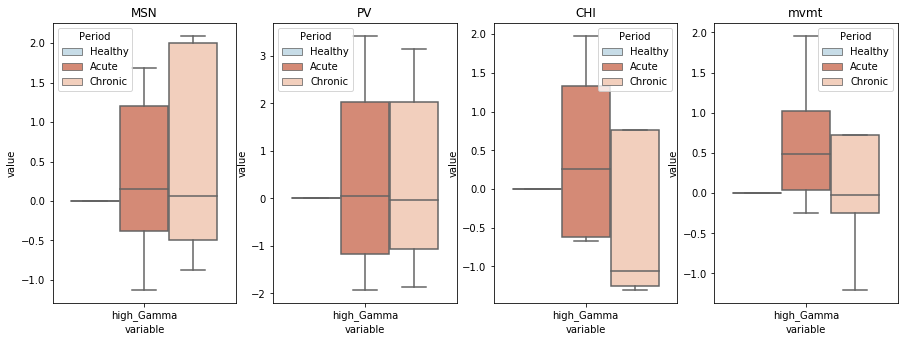

In [22]:
#Figure 6B right
Pdf = pd.read_csv(figFolder+'statsForPower_supplemental1.csv')
df2 = Pdf[Pdf.time=='post']
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma']

def nor(row,col):
    base = float(np.mean(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].values))
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)

for ind in range(len(columns)):
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)



dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,4,figsize=(15.15,5.15))#, sharey=True )

# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'], showfliers = False)

        ax[indC].set_title(c)
fig.savefig(figFolder+'figure5C.svg',transparent=True)
df3.to_csv(figFolder+'postHighGammaStats.csv')

In [69]:
Pdf = pd.read_csv(figFolder+'statsForPower.csv')
Pdf.head()
df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)

for ind in range(len(columns)):
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)


<IPython.core.display.Javascript object>


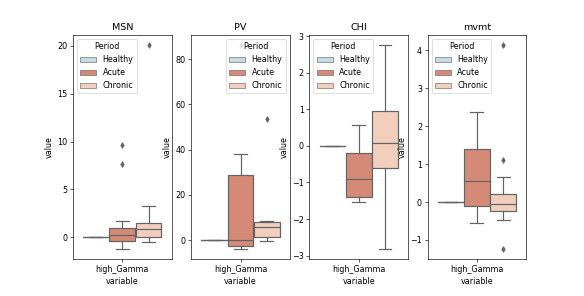

In [70]:
#Figure 6B left
# %matplotlib inline
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,4,figsize=(10.15,5.15))#, sharey=True )
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'])#, showfliers = False)
    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
# fig.savefig(figFolder+'figure6_statsBars.svg',transparent=True)
#         ax[indC,indP].set_ylim(-.5,2)


In [66]:
Pdf = pd.read_csv(figFolder+'statsForPowerPost.csv')
Pdf.head()
df2 = Pdf[(Pdf.drug=='L-Dopa')]
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    try:
        base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
        val = float(row[col])
        if base==0:
            return None
        else: #base <0 and val >0:
            return (val-base)/np.abs(base)
    except:
        return None

for ind in range(len(columns)):
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)


<IPython.core.display.Javascript object>


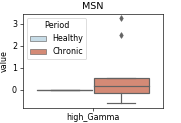

In [67]:
#Figure 6Ciii
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,1,figsize=(3.15,2.15))#, sharey=True )
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax,data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Chronic'])#, showfliers = False)
        ax.set_title(c)
# fig.savefig(figFolder+'figure6_statsBars_L-dopa_.svg',transparent=True)

In [ ]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['CRE']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'][:]
f.close()
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
df = df[(df.cre=='PV')&(df.numred>0)]
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        #tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan

        mu = np.nanmean(A[:int(A.shape[0]/2),:,:],axis=0)
        Std = np.nanstd(A[:int(A.shape[0]/2),:,:],axis=0)
        A =(A-mu)/Std
        data = []
        cols = []
        for f in ['high_Gamma','Beta']:
            highGamma = fr[f]
            A2 = A[t200,:,:][:,highGamma,:]
            b = np.arange(A2.shape[2])
            A2 = np.nanmean(np.nanmean(A2,axis = 0),axis=0)
            cols.append(f)
            data.append(A2)
        data.append(b)
        cols.append('cellNum')
        df2 = pd.DataFrame(np.array(data).T,columns = cols)
        df2['Mouse']=m
        df2['Period'] = period
        df2['Sess'] = sess
        df2['CellType'] = 'PV'

        Pdf = pd.concat([Pdf,df2])
            
        del A,b


        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - PV failed at line ",  exc_tb.tb_lineno)
            

Pdf.to_csv(figFolder+'powerElevation_PV.csv')

In [80]:
Pdf = pd.read_csv(figFolder+'powerElevation.csv')
th = Pdf[Pdf.Period=='Healthy'].high_Gamma.quantile(.95)
Pdf['gammaPercent'] = Pdf.high_Gamma.apply(lambda x: x>=th)
Pdf =Pdf.groupby(['Sess','Period']).mean()
Pdf = Pdf.reset_index()
Pdf['Mouse']=Pdf['Mouse'].astype(int)
df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig.csv')
df = df[df.population == 'MSN-MSN']
df2 = pd.merge(Pdf,df[['Sess','Period','aSymCorr']],on=['Sess','Period'])
df2


,Sess,Period,Unnamed: 0,Mouse,high_Gamma,Beta,cellNum,gammaPercent,aSymCorr
0,0761_BaselineA,Healthy,5.0,761,0.427110,0.440103,5.0,0.181818,0.021118
1,0761_BaselineL,Healthy,7.5,761,0.362527,0.932953,7.5,0.062500,0.056678
2,0761_BaselineS,Healthy,13.0,761,0.491119,0.566564,13.0,0.222222,0.061640
3,0761_day10,Acute,5.5,761,0.360169,0.007634,5.5,0.083333,0.042205
4,0761_day12,Acute,2.0,761,0.121943,0.171254,2.0,0.000000,-0.005763
...,...,...,...,...,...,...,...,...,...
205,8815_day30A,Chronic,39.0,8815,0.169259,0.328188,39.0,0.063291,0.031461
206,8815_day34L,Chronic,33.5,8815,0.085633,0.351990,33.5,0.014706,0.014564
207,8815_day4,Acute,18.0,8815,0.249947,0.256764,18.0,0.081081,0.139902
208,8815_day6,Acute,4.5,8815,0.267367,0.404598,4.5,0.200000,0.081291


----------------------------------------------------------------
aSymCorr (0.4300355942852772, 8.125339035010971e-11) 0.1849306123522917 0.18099307907863127
Healthy :
aSymCorr (0.5320198615307001, 9.954588276066515e-05) 0.2830451330631455 0.267459157694953
Acute :
aSymCorr (0.3482838526131853, 0.0004114143473149174) 0.12130164199108329 0.11224289603222848
Chronic :
aSymCorr (0.4958550017916951, 4.1655722392328946e-05) 0.24587218280184164 0.23330338584853905


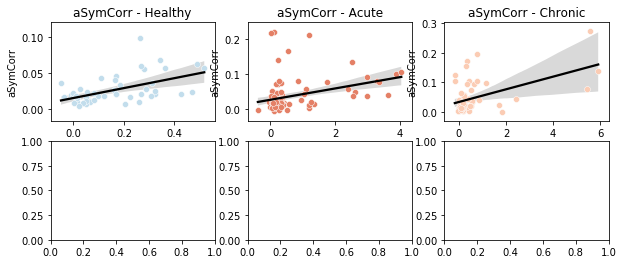

In [81]:

col = 'high_Gamma'
#col2  = 'percent_high_C'
fig, ax = plt.subplots(2,3,figsize=(10,4),sharey=False)
for indp,col2 in enumerate(['aSymCorr']):
    df3 = df2#&(df2.cre.isin(['PV','CHI']))]
#     df3[col] = df3.apply(lambda x: x[col]/df2[(df2.Period=='Healthy')&(df2.Mouse==x.Mouse)][col].mean(),axis=1 )
#     df3[col2] = df3.apply(lambda x: x[col2]/df2[(df2.Period=='Healthy')&(df2.Mouse==x.Mouse)][col2].mean(),axis=1 )
#     df3 = df3[(df3.Period=='Healthy')]
#     sns.regplot(x=col,y=col2,data = df3,color='k',marker=".",ax=ax[indp,0])
#     sns.scatterplot(x=col,y=col2,hue = 'Period',data = df3,palette=colorPallet3,ax=ax[indp,0])
#     ax[indp].set_ylim(-1.1,1.1)
#     ax[indp,0].set_title(col2+ ' - All')
#     sns.jointplot(x=col,y=col2,data = df3,hue = 'Period')#, kind="reg")
    df4 = df3[[col,col2]].dropna()
    df4['Intercept']=1
    model = sm.OLS(df4[col2], df4[['Intercept',col]])
    model_results = model.fit()
    b = model_results.params
    a =np.sum(b*df4[['Intercept',col]],axis=1)
    
    print ('----------------------------------------------------------------')
    print(col2,sci.stats.pearsonr(df4[col],df4[col2]),model_results.rsquared,model_results.rsquared_adj)
    for iPer,per in enumerate(df3.Period.unique()):
        sns.regplot(x=col,y=col2,data = df3[df3.Period == per],color='k',marker=".",ax=ax[indp,iPer])
        sns.scatterplot(x=col,y=col2,data = df3[df3.Period == per],color=colorPallet3[iPer,:],ax=ax[indp,iPer])
        ax[indp,iPer].set_title(col2 + ' - '+per)
        df4 = df3[df3.Period == per][[col,col2]].dropna()
        df4['Intercept']=1
        model = sm.OLS(df4[col2], df4[['Intercept',col]])
        model_results = model.fit()
        b = model_results.params
        a =np.sum(b*df4[['Intercept',col]],axis=1)
        print(per,':')
        print(col2,sci.stats.pearsonr(df4[col],df4[col2]),model_results.rsquared,model_results.rsquared_adj)
# fig.savefig(figFolder+'fig5E.svg',transparent=True)

<h3> Supplementals </h3>

S2

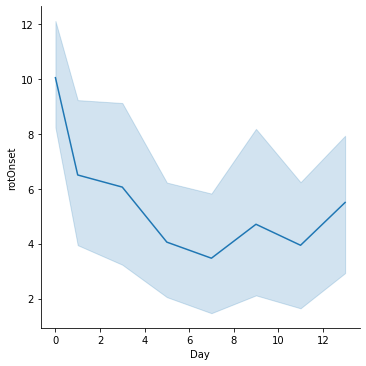

In [11]:
#figure S2i
df2 = pd.read_csv(figFolder+'rotation_forR.csv')
df2.Mouse = df2.Mouse.astype("category")
groups = df2.groupby(['Session', pd.cut(df2.Day, [-1,0,2,4,6,8,10,12,14], labels=[0,1,3,5,7,9,11,13])]).mean().drop(columns=['Day']).reset_index()

columns = ['rotOnset'] 
labels = ['% time in low Speed','% time in high Speed','# periods']
for ind in range(len(columns)):
    sns.relplot(x="Day", y=columns[ind], data=groups,kind="line")


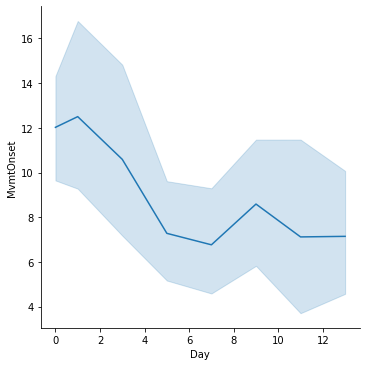

In [9]:
#Figure S2Eii
df2 = pd.read_csv(figFolder+'speedData.csv')
df2.Mouse = df2.Mouse.astype("category")
groups = df2.groupby(['Session', pd.cut(df2.Day, [-1,0,2,4,6,8,10,12,14], labels=[0,1,3,5,7,9,11,13])]).mean().drop(columns=['Day']).reset_index()

columns = ['MvmtOnset'] 
labels = ['% time in low Speed','% time in high Speed','# periods']
for ind in range(len(columns)):
    sns.relplot(x="Day", y=columns[ind], data=groups,kind="line")


s3

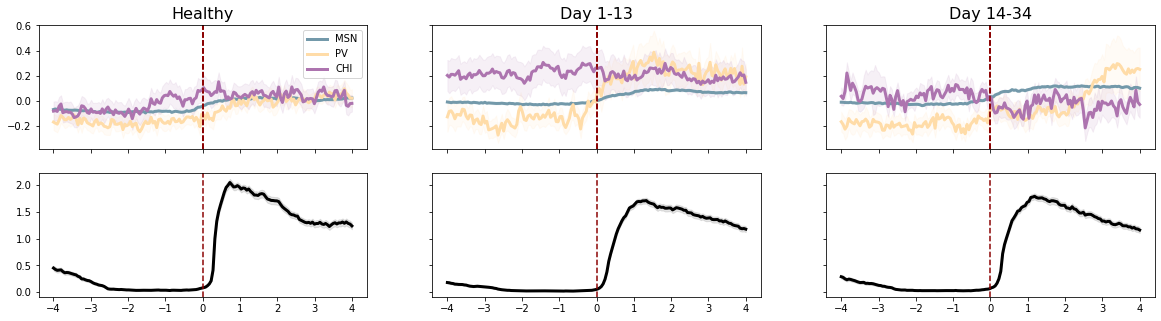

In [47]:
#Figure S3C 
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row',gridspec_kw={'height_ratios': [3,1]})
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = {'Healthy':{},'Acute':{},'Chronic':{}}

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            cOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset2') 
            acOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset2')  
            sOnset = cOnset+acOnset    
            if np.sum(sOnset) == 0:
                continue
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        quant[p][c] = sAligned
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            quant[p]['speed'] = sAlignedS
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
ax[1,0].set_title('speed')

# fig.savefig(figFolder+'figure 4a.svg',transparent=True)

In [ ]:
df = pd.DataFrame(columns=['Period','CellType','pre','post'])
for p in quant.keys():
    di = quant[p]
    for c in di.keys():
        bl = di[c][40:80]
        mu = np.mean(bl)
        std = np.std(bl)
        tr = (di[c]-mu)/std
        df2 = pd.DataFrame({'Period':p,'CellType':c,'pre':np.mean(tr[40:80],axis=0),'post':np.mean(tr[80:120],axis=0)})
        df = pd.concat([df,df2])
df.to_csv(figFolder+'fig3E_quantification_rot.csv')

MSN
__________________________________________
Healthy : S =  -22.58350624394998  P-val =  8.853987151552466e-110 True
Acute : S =  -15.192390951945486  P-val =  4.099184286449831e-51 True
Chronic : S =  -21.874071966764937  P-val =  7.410749698319421e-103 True
__________________________________________
speed
__________________________________________
Healthy : S =  -27.58462510673576  P-val =  9.1559224600266e-101 True
Acute : S =  -30.337400369555553  P-val =  1.775986777012153e-114 True
Chronic : S =  -24.60393386826417  P-val =  3.905982905861045e-87 True
__________________________________________
PV
__________________________________________
Healthy : S =  -2.6668092506605725  P-val =  0.011910042636185168 True
Acute : S =  -2.6565893502398166  P-val =  0.01795335266334847 True
Chronic : S =  -1.2342677236603947  P-val =  0.234925150605377 False
__________________________________________
CHI
__________________________________________
Healthy : S =  -1.1062935790589645  P-val =  0.

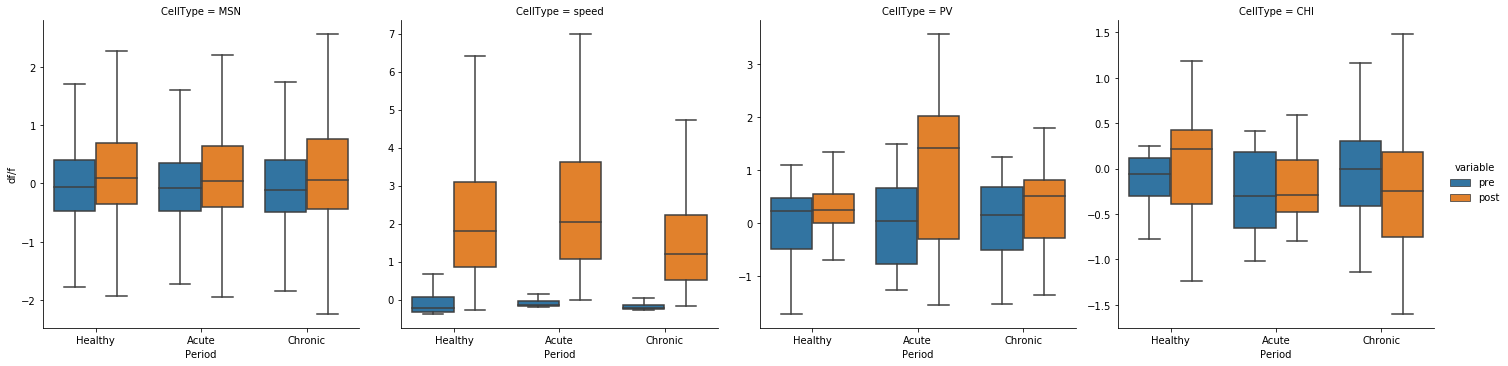

In [122]:
#Figure S3E
df = pd.read_csv(figFolder+'fig3E_quantification_rot.csv')
df2 = pd.melt(df,id_vars=['CellType','Period'], value_vars=['pre','post'],value_name='df/f')
df2
sns.catplot(x='Period',y='df/f',hue='variable',col='CellType',data=df2,
            kind='box',sharey=False,showfliers = False)
for c in df2.CellType.unique():
    print(c)
    print('__________________________________________')
    df3 = df[df.CellType==c]
    for p in df3.Period.unique():
        df4 = df3[df3.Period==p]
        #s,P  = sci.stats.wilcoxon(df4.pre, y=df4.post)
        s,P  = sci.stats.ttest_rel(df4.pre, df4.post)
        print(p,': S = ',s,' P-val = ',P,P<0.05)
    print('__________________________________________')
#plt.savefig(figFolder+'figure3S_prePost_rot_noFliers.svg',transparent=True)

MSN
 S =  9.009323209425137  P-val =  0.00012272180702810394 True 21736
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  Acute Chronic   0.0664  0.001  0.0296 0.1033   True
  Acute Healthy   0.0429 0.0137  0.0071 0.0786   True
Chronic Healthy  -0.0236  0.214 -0.0565 0.0094  False
-----------------------------------------------------
Healthy 0.2132927740395623
Acute 0.17042775277202127
Chronic 0.2368505424658208
__________________________________________
speed
 S =  28.96861570333006  P-val =  4.619498925995962e-13 True 1449
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Acute Chronic   -0.795  0.001 -1.0477 -0.5423   True
  Acute Healthy  -0.2198 0.1043 -0.4731  0.0336  False
Chronic Healthy   0.5752  0.001  0.3208  0.8296   True
-------------------------

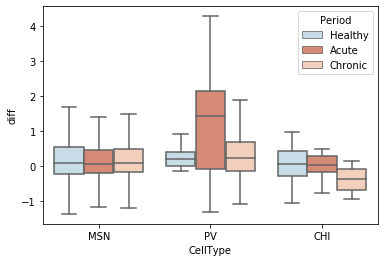

In [121]:
#Figure S3F
df = pd.read_csv(figFolder+'fig3E_quantification_rot.csv')
df['diff'] = df.apply(lambda x: x.post - x.pre, axis=1)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.boxplot(x='CellType',y='diff',hue='Period',data=df[df.CellType != 'speed'],palette=colorPallet3,showfliers=False)
for c in df.CellType.unique():
    print(c)
    #print('__________________________________________')
    df3 = df[df.CellType==c]
    s,P  = sci.stats.f_oneway(df3[df3.Period=='Healthy']['diff'].values, 
                              df3[df3.Period=='Acute']['diff'].values, df3[df3.Period=='Chronic']['diff'].values)
    print(' S = ',s,' P-val = ',P,P<0.05,df3['diff'].count())
    
    m_comp = pairwise_tukeyhsd(endog=df3['diff'].astype(float), groups=df3.Period, alpha=0.05)
         
    print(m_comp)
    for p in df3.Period.unique():
        print(p,df3[df3.Period==p]['diff'].mean())
    print('__________________________________________')
# plt.savefig(figFolder+'figure3E_new_rot.svg',transparent=True)

S5

In [11]:
# look at individual neurons - only run once 
f = h5py.File('J:\\connactivityAnalysis\\connMapsMvmt.hdf5','a')
mvmtType = {'highIpsi':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')",
            'highContra':"getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')",
            'lowRot':"getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')",
            'lowSpeed':"getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')",
            'hiSpeed':"getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')",
           'totRot':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')+getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')"}

numshifts = 1000
for m in tqdm(miceList):
    grp = f.create_group(m)
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    
       
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess in grp.keys():
            continue
        subgrp = grp.create_group(sess)

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 

        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)
        
        ssubgrp2 = subgrp.create_group('Pre')    
#         try:  
        Ca_ori = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
        dff_ori = data[sess]['trace']['dff']   

        for mv in mvmtType.keys():    
            mVector = eval(mvmtType[mv])
            if np.sum(mVector)==0:
                ssubgrp = ssubgrp2.create_group(mv)
                ssubgrp['aSymCorr'] = 0
                ssubgrp['pearson'] = 0
                ssubgrp['pearsonF'] = 0
                continue
            
            if len(mVector)<Ca_ori.shape[1]:
                mVector = np.append(mVector,0)

            Ca = Ca_ori[:,(mVector>0)]
            dff = dff_ori[:,(mVector>0)]

            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            cor3 = np.corrcoef(dff)


            ssubgrp = ssubgrp2.create_group(mv)
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
#         except:
#             print(sess)
f.close()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data


D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
<ipython-input-11-ea94137e1b82>:53: RuntimeWarning: invalid value encountered in true_divide
  cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-11-ea94137e1b82>:71: RuntimeWarning: invalid value encountered in true_divide
  sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



 43%|███████████████████████████████████▌                                               | 6/14 [05:10<05:57, 44.71s/it]C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2557: RuntimeWarning: invalid value encountered in true_divide
  return c / c

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|██████████████████████████████████████████████████████████████████████████████| 16/16 [9:41:56<00:00, 2182.27s/it]


In [ ]:
f = h5py.File('J:\\connactivityAnalysis\\connMapsMvmt.hdf5','r')
col_names = ['Mouse','Sess','Day','numred','Period','population','mvmt','personF','sPersonF']
df = pd.DataFrame(columns = col_names)
# df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
dist = {"MSN-MSN":[],"MSN-CHI":[],"MSN-PV":[]}
for m in tqdm(f.keys()):
    for sess in f[m].keys():
        for mvmt in f[m][sess]['Pre'].keys():
            try:
                numred = f[m][sess].attrs['numRed']
                cre = getCreType(Files[1],m)
                tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                    'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

                c = f[m][sess]['Pre'][mvmt]['pearson'].value 
                c[(np.tril(np.ones(c.shape),-1))==0] = np.nan

                d = f[m][sess]['Pre'][mvmt][('pearson_shuffle')].value
                b = np.nanpercentile(d,[97.5,2.5],axis=2)
                d = np.nanmean(d,axis=2)
                d[(np.tril(np.ones(d.shape),-1))==0] = np.nan
                
                nSig = (c>b[0,:,:])|(c<b[1,:,:])
                cSig = np.copy(c)
                cSig[~nSig] = np.nan
                noSig = np.copy(c)
                noSig[nSig] = np.nan

                if numred > 1:
                    tempDict['population'] = cre+'-'+cre
                    tempDict['mvmt'] = mvmt
                    tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                    tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
                    tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
                    tempDict['sigPercent'] = np.nansum(nSig[:numred,:numred]==1)/np.nansum(np.isnan(c[:numred,:numred])==0)
                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                if numred > 0:
                    tempDict['mvmt'] = mvmt
                    tempDict['population'] = 'MSN-'+cre
                    tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                    tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
                    tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
                    tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)

                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
#                     hi,bi = np.histogram(c[numred:,:numred],np.arange(-1,1,0.01))
#                     hi2,bi2 = np.histogram(cSig[numred:,:numred],np.arange(-1,1,0.01))
#                     df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                     'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                       'population':'MSN-'+cre,'mvmt':mvmt,'values':hi,'values_sig':hi2},ignore_index=True)

                    
                
                tempDict['mvmt'] = mvmt
                tempDict['population'] = 'MSN-MSN'
                tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
                tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
#                 hi,bi = np.histogram(c[numred:,numred:],np.arange(-1,1,0.01))
#                 hi2,bi2 = np.histogram(cSig[numred:,numred:],np.arange(-1,1,0.01))
#                 df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                 'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                   'population':'MSN-MSN','mvmt':mvmt,'values':hi,'values_sig':hi2},ignore_index=True)
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'mvmtCorrSig.csv')
# df3.to_csv(figFolder+'mvmtCorrSig_hists.csv')

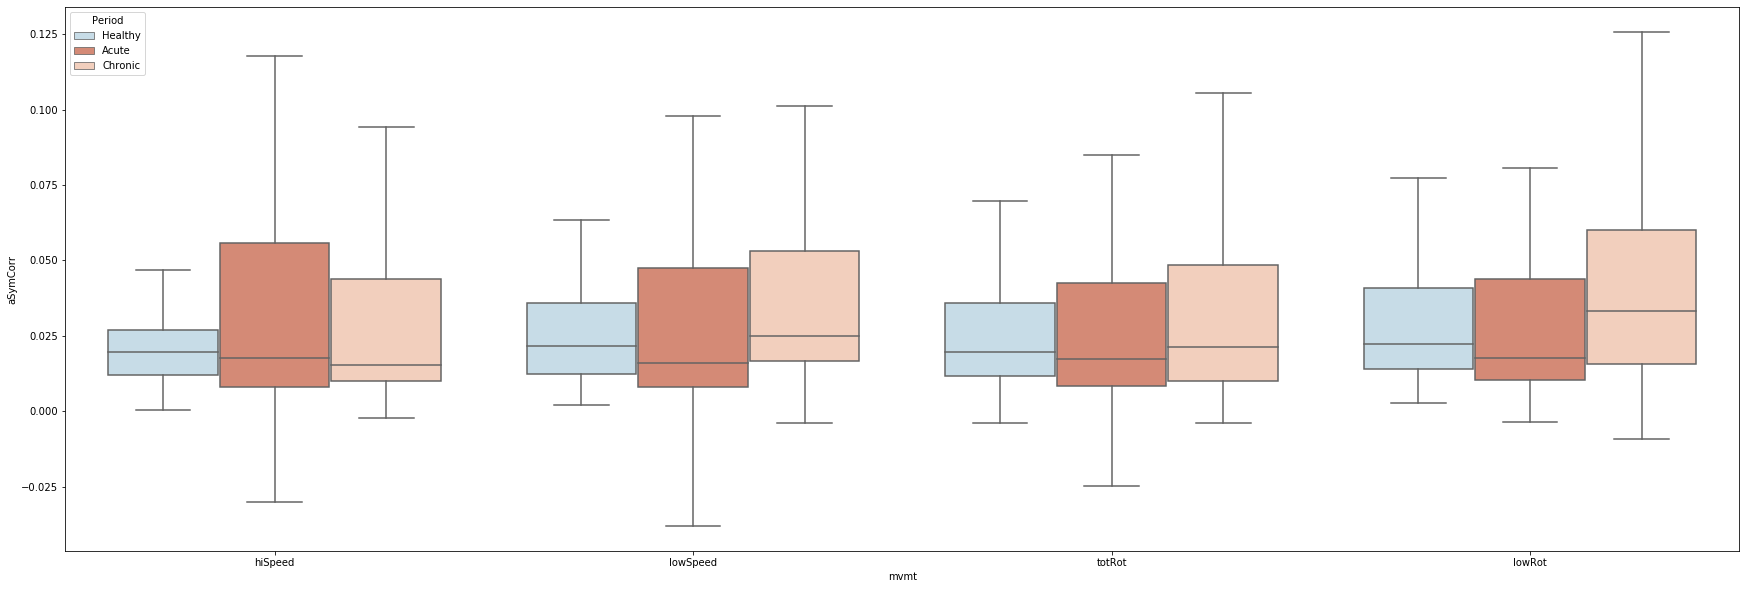

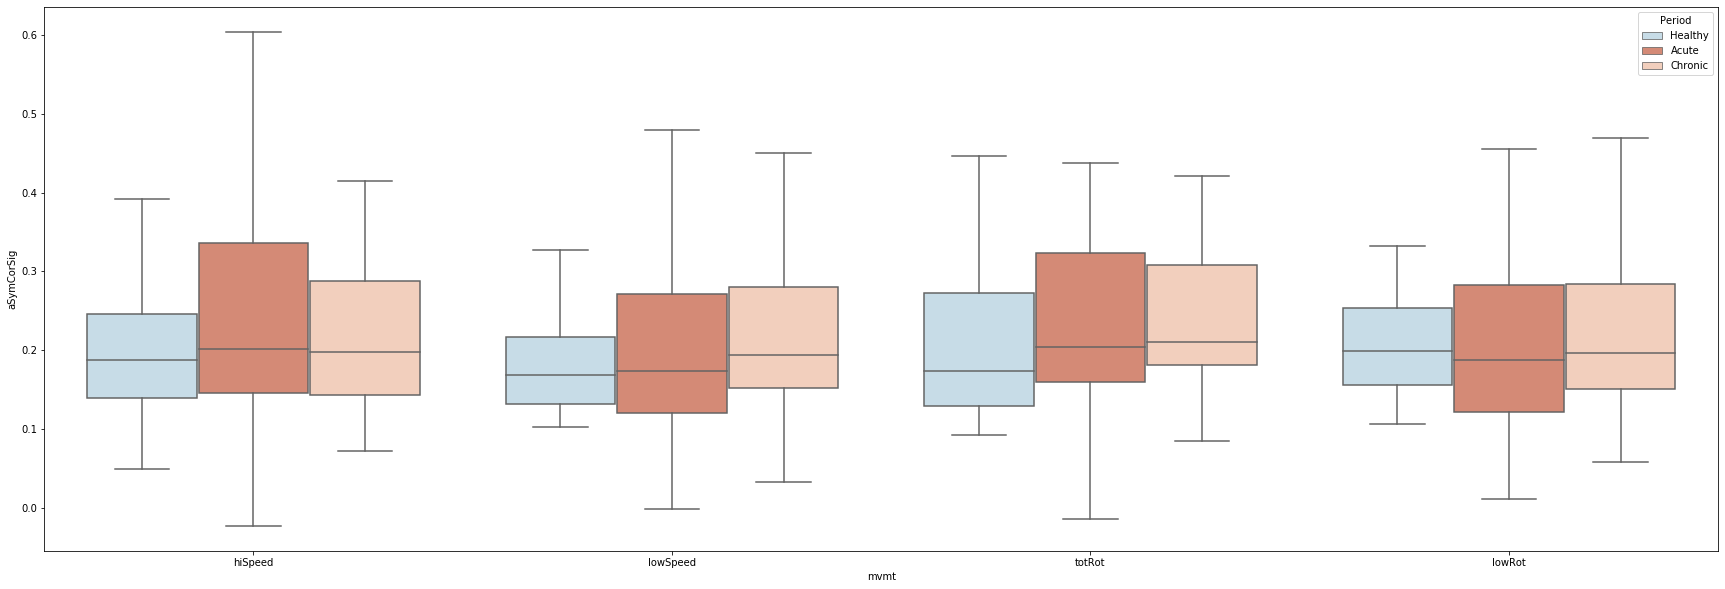

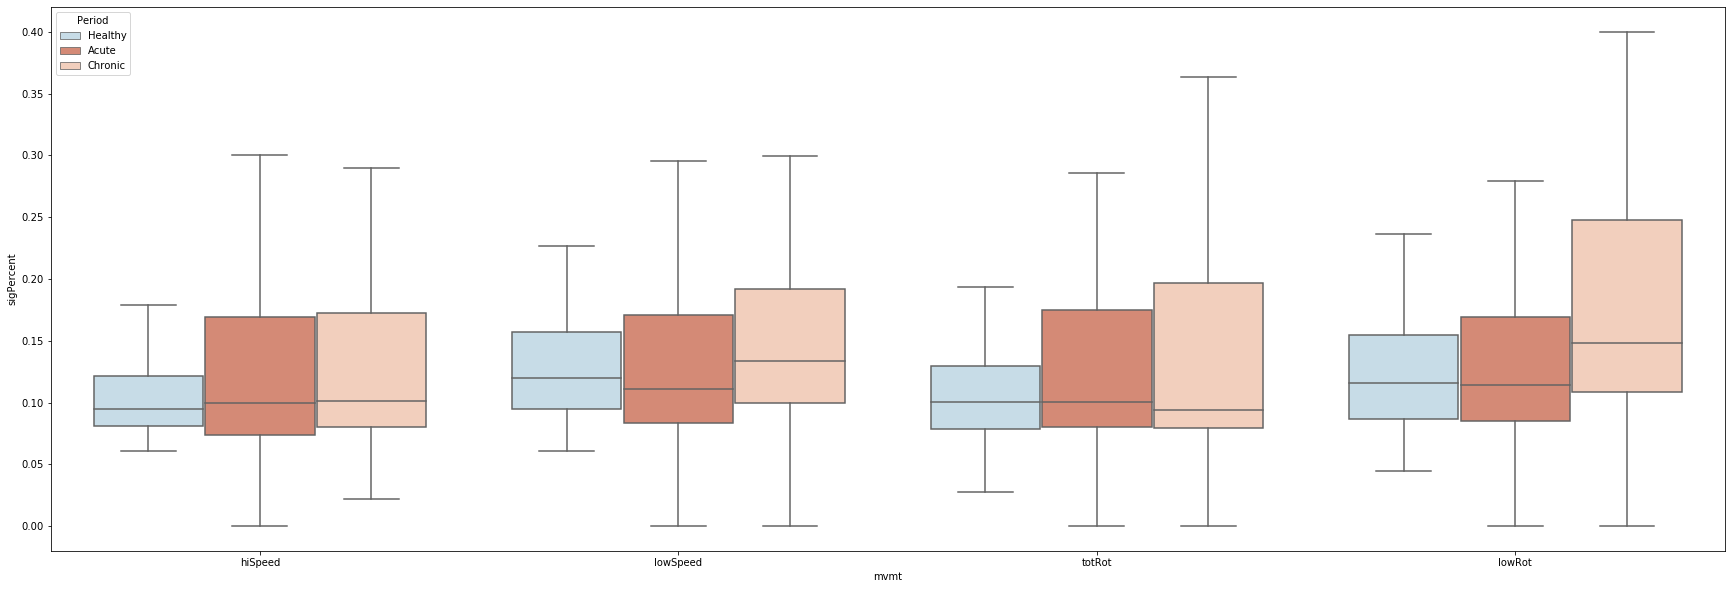

In [116]:
#S5 C,E,G
f = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
for col in ["aSymCorr","aSymCorrSig","sigPercent"]:
    fig, ax  = plt.subplots(1,1,figsize=(30, 10),sharey = True)
    indF = 0;
    with sns.color_palette(colorPallet3):
        sns.boxplot(x = 'mvmt' ,hue="Period", y=col,#ax = ax[indF],
                    data=df[(df.population == "MSN-MSN")],
                    hue_order = ['Healthy', 'Acute', 'Chronic'], order = ['hiSpeed', 'lowSpeed', 'totRot','lowRot'],
                    showfliers = False)
#         ax[indF].set_title(mvmt)
        indF = indF + 1
    #fig.savefig(figFolder+'figureS5_'+col+'_MSN.svg',format='svg')


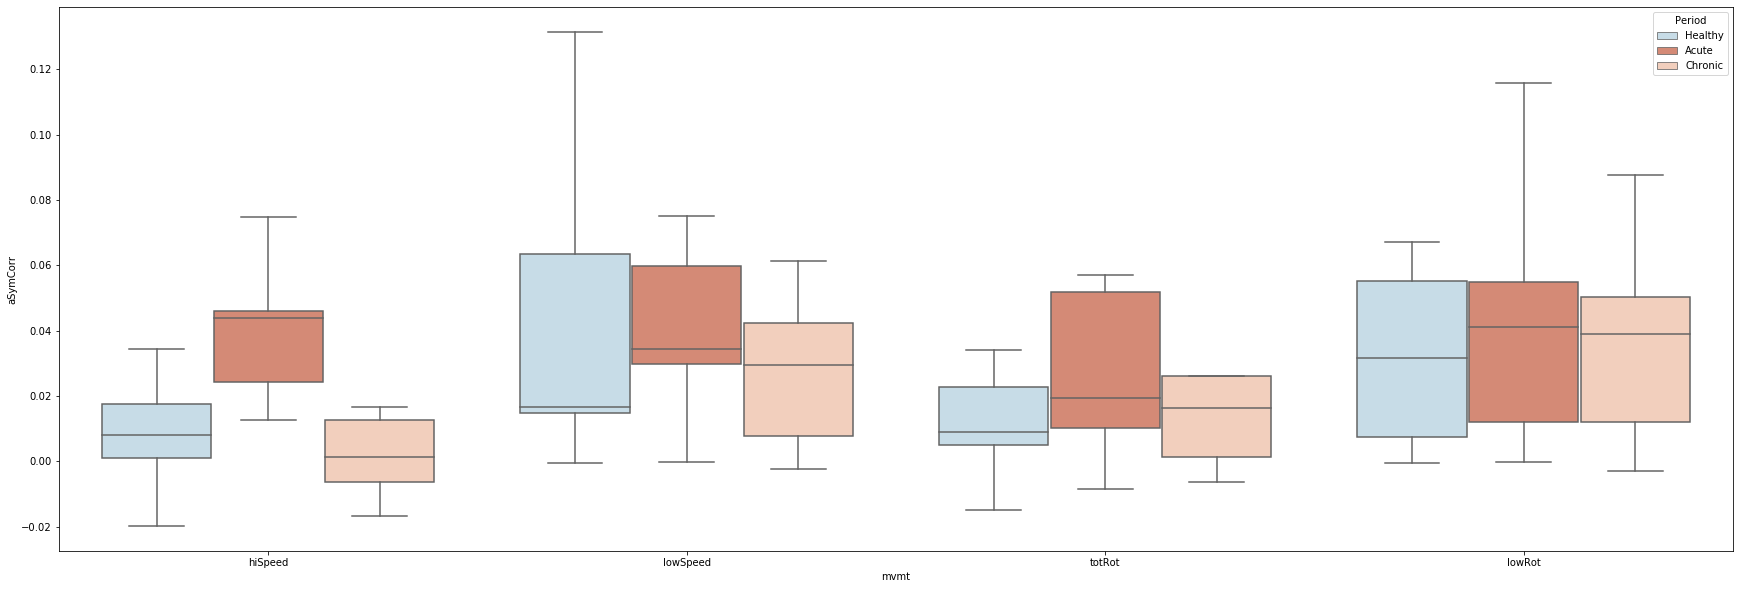

In [118]:
#Figure S5 D
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
for col in ["aSymCorr"]:
    fig, ax  = plt.subplots(1,1,figsize=(30, 10),sharey = True)
    indF = 0;
    with sns.color_palette(colorPallet3):
        sns.boxplot(x = 'mvmt' ,hue="Period", y=col,#ax = ax[indF],
                    data=df[(df.population == "MSN-CHI")],
                    hue_order = ['Healthy', 'Acute', 'Chronic'], order = ['hiSpeed', 'lowSpeed', 'totRot','lowRot'],
                    showfliers = False)
#         ax[indF].set_title(mvmt)
        indF = indF + 1
    #fig.savefig(figFolder+'figureS5_'+col+'_CHI.svg',format='svg')


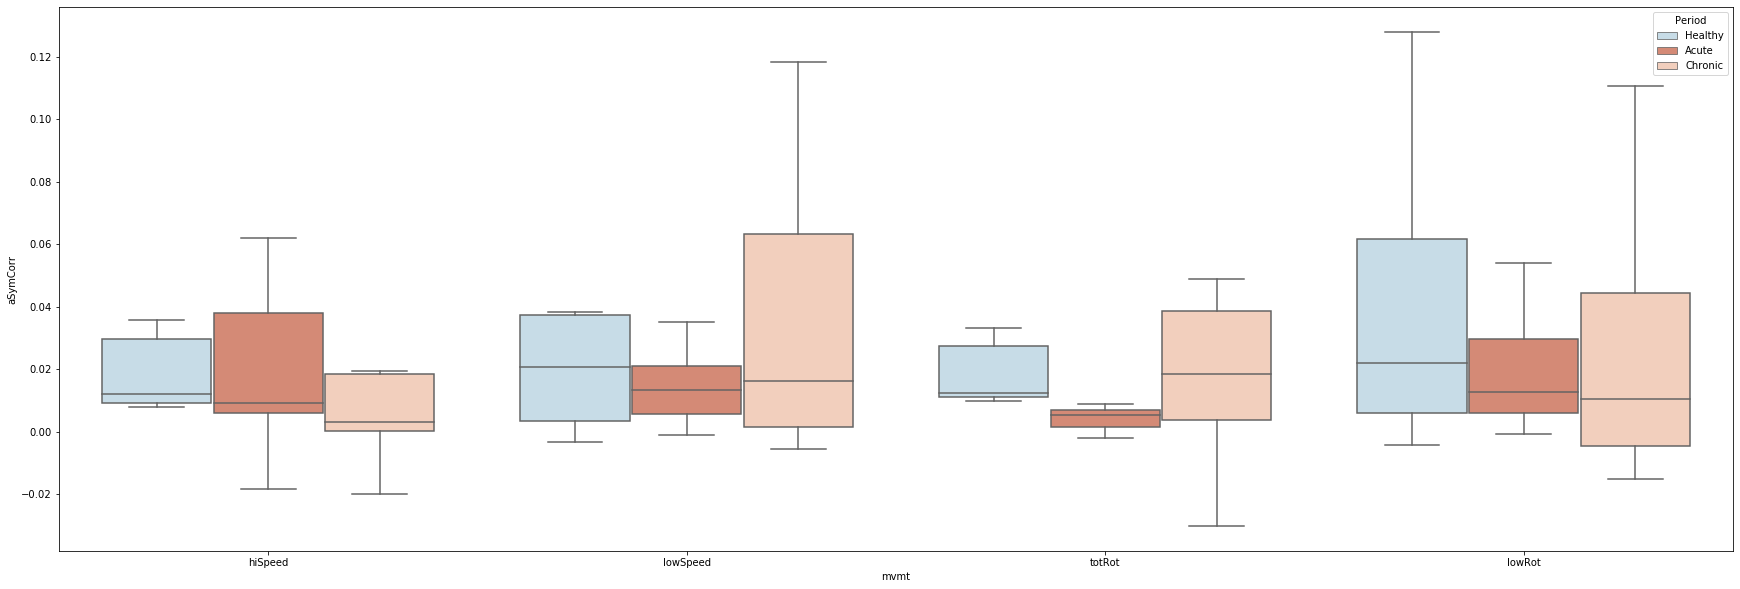

In [119]:
#Figure S5 F
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
for col in ["aSymCorr"]:
    fig, ax  = plt.subplots(1,1,figsize=(30, 10),sharey = True)
    indF = 0;
    with sns.color_palette(colorPallet3):
        sns.boxplot(x = 'mvmt' ,hue="Period", y=col,#ax = ax[indF],
                    data=df[(df.population == "MSN-PV")],
                    hue_order = ['Healthy', 'Acute', 'Chronic'], order = ['hiSpeed', 'lowSpeed', 'totRot','lowRot'],
                    showfliers = False)
#         ax[indF].set_title(mvmt)
        indF = indF + 1
    #fig.savefig(figFolder+'figureS5_'+col+'_PV.svg',format='svg')


s6

In [92]:
Pdf = pd.read_csv(figFolder+'statsForPower.csv')
Pdf.head()
df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)

for ind in range(len(columns)):
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)

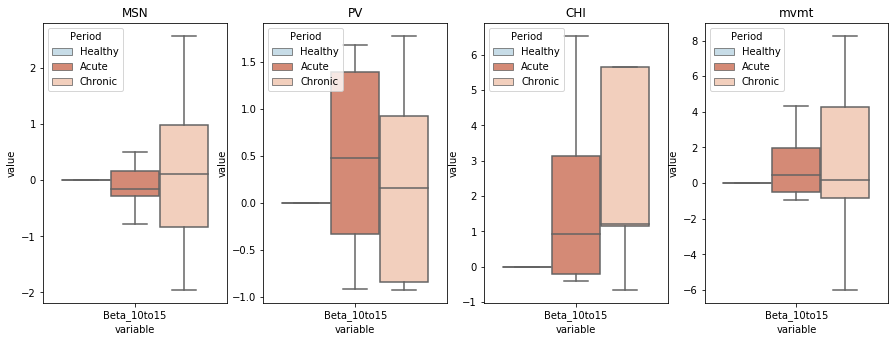

In [96]:
# Figure S6B
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['Beta_10to15'])
fig, ax = plt.subplots(1,4,figsize=(15.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'], showfliers = False)

        ax[indC].set_title(c)
fig.savefig(figFolder+'figure6_statsBars_Beta.svg',transparent=True)


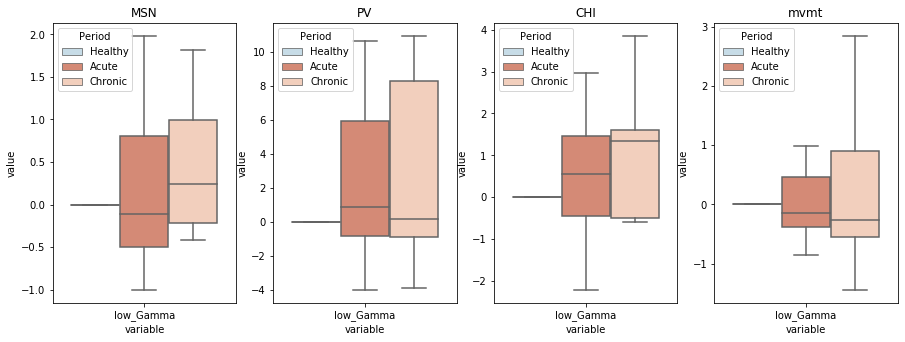

In [95]:
# Figure S6C
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['low_Gamma'])
fig, ax = plt.subplots(1,4,figsize=(15.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'], showfliers = False)

        ax[indC].set_title(c)
fig.savefig(figFolder+'figure6_statsBars_lowGamma.svg',transparent=True)


CHI :
Healthy
 pre vs. s200: - p =  0.4955208830566151  sig =  False
Acute
 pre vs. s200: - p =  0.463071015014588  sig =  False
Chronic
 pre vs. s200: - p =  0.4235963177660037  sig =  False
MSN :
Healthy
 pre vs. s200: - p =  1.2527877792386235e-08  sig =  True
Acute
 pre vs. s200: - p =  1.1784724308298542e-15  sig =  True
Chronic
 pre vs. s200: - p =  1.8957136631193694e-10  sig =  True
PV :
Healthy
 pre vs. s200: - p =  0.7221076526150257  sig =  False
Acute
 pre vs. s200: - p =  0.008375372965971843  sig =  True
Chronic
 pre vs. s200: - p =  0.007598223082063245  sig =  True
mvmt :
Healthy
 pre vs. s200: - p =  7.627021384647336e-08  sig =  True
Acute
 pre vs. s200: - p =  1.0147015348525326e-14  sig =  True
Chronic
 pre vs. s200: - p =  2.1641214402421174e-09  sig =  True


C:\Users\dzemel\Miniconda3\lib\site-packages\scipy\stats\morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
C:\Users\dzemel\Miniconda3\lib\site-packages\scipy\stats\morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


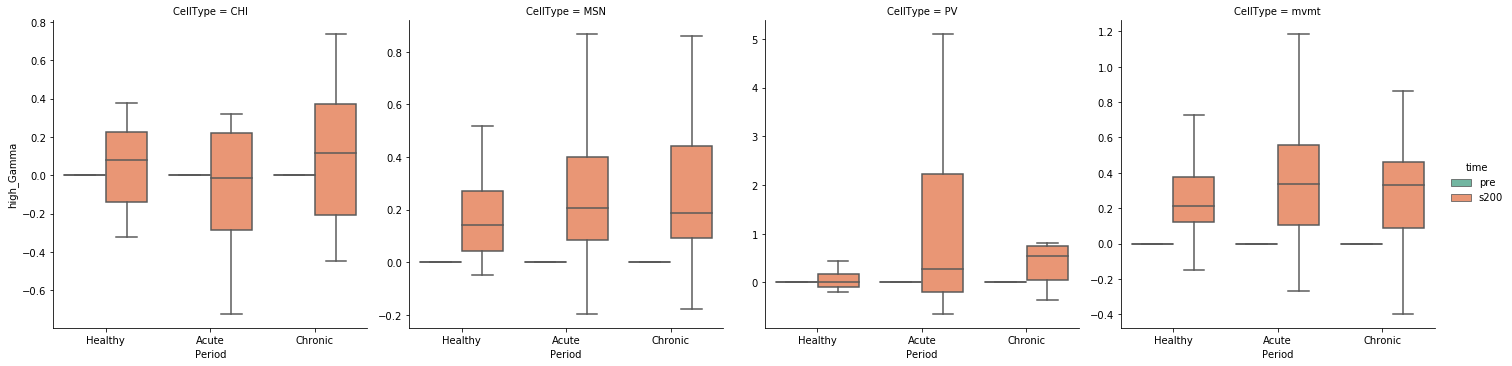

In [29]:
#Figure S6D
Pdf = pd.read_csv(figFolder+'statsForPower_supplemental1.csv')
# Pdf = Pdf[Pdf.CellType.isin(['MSN'])]
sns.catplot(data = Pdf,col = 'CellType', y = 'high_Gamma', hue = 'time',x = 'Period',kind='box' ,
            sharey =False, showfliers = False, hue_order = ['pre','s200'], palette = sns.color_palette("Set2"))
for c in Pdf.CellType.unique():
    d = Pdf[Pdf.CellType == c]
    print(c,':')
    for per in d.Period.unique():
        df4 = d[d.Period == per]
#         S,P = sci.stats.wilcoxon(df4[df4.time=='pre'].high_Gamma.values,y=df4[df4.time=='post'].high_Gamma.values)
#         S2,P2 = sci.stats.wilcoxon(df4[df4.time=='s200'].high_Gamma.values,y=df4[df4.time=='post'].high_Gamma.values)
        S3,P3 = sci.stats.wilcoxon(df4[df4.time=='s200'].high_Gamma.values,y=df4[df4.time=='pre'].high_Gamma.values)
        print(per)
#         print(' pre vs. post: - p = ',P*3,' sig = ',P<0.05)
        print(' pre vs. s200: - p = ',P3,' sig = ',P3<0.05 )
#         print(' s200 vs. post: - p = ',P2,' sig = ',P2<0.05 )

# plt.plot(tPlot,t200['pre'])

plt.savefig(figFolder+'figureS8D_new2.svg',transparent=True)

In [118]:
# Recalculate the LFP align to contra rotation onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2ACrot/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


 46%|████▌     | 6/13 [00:36<00:42,  6.10s/it]

found  17.0  outlier points


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 64%|██████▍   | 9/14 [00:50<00:27,  5.46s/it]

found  888231.0  outlier points


 71%|███████▏  | 10/14 [00:56<00:22,  5.60s/it]

found  481139.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 93%|█████████▎| 13/14 [01:10<00:05,  5.53s/it]

8803_day6


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 93%|█████████▎| 13/14 [01:13<00:05,  5.52s/it]

8815_day6


100%|██████████| 14/14 [01:18<00:00,  5.64s/it]


In [119]:
# Recalculate the LFP align to ipsi rotation onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2Crot/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  7%|▋         | 1/14 [00:05<01:17,  5.99s/it]

found  1.0  outlier points


 64%|██████▍   | 9/14 [00:46<00:27,  5.41s/it]

found  888231.0  outlier points


 71%|███████▏  | 10/14 [00:52<00:22,  5.63s/it]

found  481139.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 7/14 [00:38<00:38,  5.53s/it]

found  50.0  outlier points


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████| 14/14 [00:56<00:00,  4.04s/it]

8803_day6



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████| 14/14 [00:49<00:00,  3.56s/it]

8815_day6


In [126]:
# Figure S6Aii
df = pd.read_csv('/home/dana_z/HD1/lfp2Crot/sessions')
savePath = '/home/dana_z/HD1/lfp2Crot/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmin =-0.75,vmax = 1.5 )
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_'+per+'Crot_normalizedByonset.png',format='png')
#     fig.savefig(figFolder+'figureS3_'+per+'ipsi.svg',format='svg')
    fig.clf()
    plt.close(fig)



In [250]:
#Figure S6Ai
df = pd.read_csv('/home/dana_z/HD1/lfp2ACrot/sessions')
savePath = '/home/dana_z/HD1/lfp2ACrot/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    print(A.shape)
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmin = -0.75,vmax = 1.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_'+per+'ACrot_normalizedByonset.png',format='png')
#     fig.savefig(figFolder+'figureS3_'+per+'contra.svg',format='svg')
    fig.clf()
    plt.close(fig)
    


(12206, 87, 245)
(12206, 87, 323)
(12206, 87, 288)
